# This R script takes results from elastic net Cox regression and xgboost models from the accompanying Python script

## It is used to benchmark model performance, highlight the most important features, and build figures

# Load packages 

In [1]:
library(data.table)
library(survival)
library(survminer)
library(tableone)
library(ggplot2)
library(GGally)
library(patchwork)
library(gtools)
library(plyr)
library(Hmisc)
library(mltools)
library(RColorBrewer)
library(ResourceSelection)
library(pROC)
library(corrplot)

Loading required package: ggplot2

Warning message:
"replacing previous import 'vctrs::data_frame' by 'tibble::data_frame' when loading 'dplyr'"
Loading required package: ggpubr

Loading required package: magrittr

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: 'plyr'


The following object is masked from 'package:ggpubr':

    mutate


Loading required package: lattice

Loading required package: Formula


Attaching package: 'Hmisc'


The following objects are masked from 'package:plyr':

    is.discrete, summarize


The following objects are masked from 'package:base':

    format.pval, units


ResourceSelection 0.3-4 	 2019-01-08

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


corrplot 0.84 loaded



# Custom functions for model evaluation:

## absolute_risk
- Inputs: CoxPH model and datatable with all variables in CoxPH model on which to predict
- Estimates baseline survival at 10 years (consistent throughout this study) and then estimates 10-year risk for incident outcome for a Cox proportional hazards model

In [2]:
absolute_risk <- function(coxmodel,data){
    cumhaz <- basehaz(coxmodel,centered = TRUE) #Note that this is centered at mean covariates
    basesurv <- exp(-1*cumhaz$hazard[which.min(abs(cumhaz$time - 3652))])
    print(paste0("S_o(10) = ",round(basesurv,3)))
    
    tenyrpredict <- 1 - basesurv^(predict(coxmodel,data,type="risk"))
    return(tenyrpredict)
}

## calibration_plot
- Inputs: datatable with predicted risk, event column 0/1
- Compares mean predicted risk versus mean observed risk within deciles of predicted risk
- Plots a calibration plot containing a p-value corresponding to Hosmer-Lemeshow test

In [3]:
calibration_plot <- function(data,predictioncol,eventcol,manualpvalue=NULL){
    if(any(is.na(cbind(data[[predictioncol]],data[[eventcol]])))){
        warning('at least 1 NA entry in predictioncol or eventcol')
    }
    
    pred_quantiles <- quantcut(data[[predictioncol]],q=10)
    pred_mean <- tapply(data[[predictioncol]],pred_quantiles,mean)
    event_mean <- tapply(data[[eventcol]],pred_quantiles,mean)
    data.lm <- lm(event_mean ~ pred_mean)
#     print(data.lm)
    
    num <- round_any(max(max(pred_mean),max(event_mean))*1.4,0.05)
#     print(max(pred_mean))
#     print(max(event_mean))
#     print(num)
    
    
    
#     print(pred_mean)
#     print(event_mean)
#     print(cbind(pred_mean,event_mean))
    
    #Greenwood-Nam-D'Agostino
#     gnd_result <- GND.calib(pred=data[[predictioncol]],tvar=pmin(data[[timetoeventcol]],censortime),
#                            out=data[[eventcol]],cens.t=data[[censorcol]],groups=pred_quantiles,
#                            adm.cens=censortime)
#     print(paste0('GND: ',gnd_result))
    
    hoslem_result <- hoslem.test(x=data[[predictioncol]],y=as.numeric(data[[eventcol]]),g=10)
#     print(paste0('HL: ',hoslem_result))
    HLpval <- round(hoslem_result$p.value,3)
    HLpvalprint <- paste0("p-value = ",HLpval)
    
    if(!is.null(manualpvalue)) HLpvalprint <- manualpvalue
    
    g1 <- ggplot(data=as.data.frame(cbind(pred_mean,event_mean)),aes(x=pred_mean,y=event_mean)) + 
    geom_point() + 
    geom_abline(intercept=0,slope=1,linetype="dashed") + 
    geom_abline(intercept=data.lm$coefficients[['(Intercept)']],slope=data.lm$coefficients[['pred_mean']],color="red") +
    scale_x_continuous(limits=c(0,num),breaks=seq(0,num,by=0.05)) +
    scale_y_continuous(limits=c(0,num),breaks=seq(0,num,by=0.05)) + 
    xlab("Predicted 10-year Cumulative Incidence") +
    ylab("Observed 10-year Cumulative Incidence") +
    theme_classic() +
    theme(text = element_text(size=16)) +
    annotate("text",x=0.8*num,y=0.2*num,size=6,label=paste0("m = ",round(data.lm$coefficients[['pred_mean']],2))) +
    annotate("text",x=0.8*num,y=0.15*num,size=6,label=paste0("b = ",round(data.lm$coefficients[['(Intercept)']],3))) +
    annotate("text",x=0.8*num,y=0.10*num,size=6,label=HLpvalprint)
    return(g1)
}

## reclass
- Takes in data.table with observed outcome, risk predicted by model 1, risk predicted by model 2, and the cutoff around which the compare the behaviors of models 1 and 2
- Computes reclassification metrics

In [4]:
reclass <- function(data,cOutcome,predrisk1,predrisk2,cutoff){
 
c1 <- cut(predrisk1,breaks = cutoff ,include.lowest=TRUE,right= FALSE)
c2 <- cut(predrisk2,breaks = cutoff ,include.lowest=TRUE,right= FALSE)
tabReclas <- table("Initial Model"=c1, "Updated Model"=c2)
cat(" _________________________________________\n")
cat(" \n     Reclassification table    \n")
cat(" _________________________________________\n")
 
 ta<- table(c1, c2, data[[cOutcome]])
    print(ta)
 
  cat ("\n Outcome: absent \n  \n" )
  TabAbs <- ta[,,1]
  tab1 <- cbind(TabAbs, " % reclassified"= round((rowSums(TabAbs)-diag(TabAbs))/rowSums(TabAbs),2)*100)
  names(dimnames(tab1)) <- c("Initial Model", "Updated Model")
  print(tab1)
 
  cat ("\n \n Outcome: present \n  \n" )
  TabPre <- ta[,,2]
  tab2 <- cbind(TabPre, " % reclassified"= round((rowSums(TabPre)-diag(TabPre))/rowSums(TabPre),2)*100)
  names(dimnames(tab2)) <- c("Initial Model", "Updated Model")
  print(tab2)
 
  cat ("\n \n Combined Data \n  \n" )
  Tab <- tabReclas
  tab <- cbind(Tab, " % reclassified"= round((rowSums(Tab)-diag(Tab))/rowSums(Tab),2)*100)
  names(dimnames(tab)) <- c("Initial Model", "Updated Model")
  print(tab)
cat(" _________________________________________\n")
 
c11 <-factor(c1, levels = levels(c1), labels = c(1:length(levels(c1))))
c22 <-factor(c2, levels = levels(c2), labels = c(1:length(levels(c2))))
 
  x<-improveProb(x1=as.numeric(c11)*(1/(length(levels(c11)))),
  x2=as.numeric(c22)*(1/(length(levels(c22)))), y=data[[cOutcome]])
 
 
y<-improveProb(x1=predrisk1, x2=predrisk2, y=data[[cOutcome]])

 
cat("\n NRI(Categorical) [95% CI]:", round(x$nri,4),"[",round(x$nri-1.96*x$se.nri,4),"-",
 round(x$nri+1.96*x$se.nri,4), "]", "; p-value:", round(2*pnorm(-abs(x$z.nri)),5), "\n" )
 
 cat(" NRI(Continuous) [95% CI]:", round(y$nri,4),"[",round(y$nri-1.96*y$se.nri,4),"-",
 round(y$nri+1.96*y$se.nri,4), "]", "; p-value:", round(2*pnorm(-abs(y$z.nri)),5), "\n" )
    
cat(" NRIevent(Continuous) [95% CI]:", round(y$nri.ev,4),"[",round(y$nri.ev-1.96*y$se.nri.ev,4),"-",
 round(y$nri.ev+1.96*y$se.nri.ev,4), "]", "; p-value:", round(2*pnorm(-abs(y$z.nri.ev)),5), "\n" )
    
cat(" NRInonevent(Continuous) [95% CI]:", round(y$nri.ne,4),"[",round(y$nri.ne-1.96*y$se.nri.ne,4),"-",
 round(y$nri.ne+1.96*y$se.nri.ne,4), "]", "; p-value:", round(2*pnorm(-abs(y$z.nri.ne)),5), "\n" )
 
cat(" IDI [95% CI]:", round(y$idi,4),"[",round(y$idi-1.96*y$se.idi,4),"-",
 round(y$idi+1.96*y$se.idi,4), "]","; p-value:", round(2*pnorm(-abs(y$z.idi)),5), "\n")
    
#     return(y)
}


# Part 1: Read all necessary files and check for missing

## Descriptive information for full UKBB (n = 502504)

In [5]:
#Master data.table with UKB ids and many descriptive variables relevant to PCE
masterdfukb <- fread("/medpop/esp2/sagrawal/prs_crs_integration/prs_crs_masterdf_ascvd_sbpavg.csv")

#Hard CAD
CAD_SA <- fread("CAD_SA.csv")

#CVD outcome
CVD_Elliot <- fread('/medpop/esp2/sagrawal/prs_crs_integration/Elliot_CVD_analysisready.csv')

#QRISK3 for UKBB
qrisk <- fread("/medpop/esp2/aniruddh/SouthAsians/Qriskscoresnonmissingnew.txt")
qrisk$qrisk3 <- qrisk$QRISK3_2017/100

#Processing Hard CAD outcome file to include 10 year outcome
CAD_SA <- CAD_SA[,c("eid","incident_disease","fu_days","fu_yrs")]
names(CAD_SA) <- c("eid","CAD_incident_disease","CAD_fu_days","CAD_fu_yrs")
CAD_SA$CAD_tenyearoutcome <- 0
CAD_SA[CAD_incident_disease == 1 & 
       CAD_fu_days <= 3652.5]$CAD_tenyearoutcome <- 1
CAD_SA$CAD_tenyearcensor <- ifelse(CAD_SA$CAD_fu_days > 3652.5,1,0)

CVD_Elliot <- CVD_Elliot[,c("eid","incident_disease","fu_days","fu_yrs")]
names(CVD_Elliot) <- c("eid","CVD_incident_disease","CVD_fu_days","CVD_fu_yrs")
CVD_Elliot$CVD_tenyearoutcome <- 0
CVD_Elliot[CVD_incident_disease == 1 & 
       CVD_fu_days <= 3652.5]$CVD_tenyearoutcome <- 1
CVD_Elliot$CVD_tenyearcensor <- ifelse(CVD_Elliot$CVD_fu_days > 3652.5,1,0)

masterdf1 <- merge(masterdfukb,CAD_SA,by="eid")
masterdf1 <- merge(masterdf1,CVD_Elliot,by="eid")
masterdf <- merge(masterdf1,qrisk[,c('ID','qrisk3')],by.x='eid',by.y='ID',all=TRUE)

#Groups made of self-reported race/ethnicity
whiteonlyvec <- c("Any_other_white_background","British","Irish","White")
southasianvec <- c("Bangladeshi","Indian","Pakistani")
asianminusSA <- c("Any_other_Asian_background","Asian_or_Asian_British","Chinese","White_and_Asian")
blackvec <- c("African","Any_other_Black_background","Black_or_Black_British","Caribbean","White_and_Black_African","White_and_Black_Caribbean")
othervec <- c("Any_other_mixed_background","Mixed","Other_ethnic_group","Do_not_know","Prefer_not_to_answer") #is.na in this too in terms of PC similarity

masterdf$sex_strat <- ifelse(masterdf$sex == "Male",1,0)

masterdf$ethnicity_white <- ifelse(masterdf$ethnicity %in% whiteonlyvec,1,0)

masterdf$ethnicity_black <- ifelse(masterdf$ethnicity %in% blackvec,1,0)

masterdf$ethnicity_asian <- ifelse(masterdf$ethnicity %in% asianminusSA,1,0)

masterdf$ethnicity_southasian <- ifelse(masterdf$ethnicity %in% southasianvec,1,0)

masterdf$ethnicity_other <- ifelse((masterdf$ethnicity %in% othervec) | is.na(masterdf$ethnicity),1,0)

masterdf$ethnicity_group <- "placeholder"
masterdf[ethnicity_white==1]$ethnicity_group <- "White"
masterdf[ethnicity_black==1]$ethnicity_group <- "Black"
masterdf[ethnicity_asian==1]$ethnicity_group <- "East Asian"
masterdf[ethnicity_southasian==1]$ethnicity_group <- "South Asian"
masterdf[ethnicity_other==1]$ethnicity_group <- "Other"

masterdf$ethnicity_group <- factor(masterdf$ethnicity_group,levels=c('Black','South Asian','East Asian','White','Other'))

In [6]:
# Defined this for the purpose of recalibration

masterdf$age_group <- "G1" #(age < 45, basically meaning 40-45)
masterdf[age >= 45 & age < 50]$age_group <- "G2"
masterdf[age >= 50 & age < 55]$age_group <- "G3"
masterdf[age >= 55 & age < 60]$age_group <- "G4"
masterdf[age >= 60 & age < 65]$age_group <- "G5"
masterdf[age >= 65 & age < 70]$age_group <- "G6"
masterdf[age >= 70 & age < 75]$age_group <- "G7"

masterdf$ageG2 <- ifelse(masterdf$age_group=='G2',1,0)
masterdf$ageG3 <- ifelse(masterdf$age_group=='G3',1,0)
masterdf$ageG4 <- ifelse(masterdf$age_group=='G4',1,0)
masterdf$ageG5 <- ifelse(masterdf$age_group=='G5',1,0)
masterdf$ageG6 <- ifelse(masterdf$age_group=='G6',1,0)
masterdf$ageG7 <- ifelse(masterdf$age_group=='G7',1,0)

In [7]:
#Define a secondary follow-up time variable that cuts off at 10 years
masterdf[CAD_fu_days >= 3652,CAD_fu_days10yr:=3652]
masterdf[CAD_fu_days < 3652,CAD_fu_days10yr:=CAD_fu_days]

Warning message in `[.data.table`(masterdf, CAD_fu_days < 3652, `:=`(CAD_fu_days10yr, :
"Coerced integer RHS to double to match the type of the target column (column 67 named 'CAD_fu_days10yr'). If the target column's type double is correct, it's best for efficiency to avoid the coercion and create the RHS as type double. To achieve that consider R's type postfix: typeof(0L) vs typeof(0), and typeof(NA) vs typeof(NA_integer_) vs typeof(NA_real_). You can wrap the RHS with as.double() to avoid this warning, but that will still perform the coercion. If the target column's type is not correct, it's best to revisit where the DT was created and fix the column type there; e.g., by using colClasses= in fread(). Otherwise, you can change the column type now by plonking a new column (of the desired type) over the top of it; e.g. DT[, `CAD_fu_days10yr`:=as.integer(`CAD_fu_days10yr`)]. If the RHS of := has nrow(DT) elements then the assignment is called a column plonk and is the way to change a c

In [8]:
#Adjusting PRS for ancestry

pcmod1 <- lm(prs ~ PC1+PC2+PC3+PC4, data=masterdf)
masterdf$prs_resid <- masterdf$prs - predict(pcmod1,masterdf)

In [9]:
##Importing additional descriptive variables I want

ldl <- fread("/medpop/esp2/sagrawal/prs_crs_integration/labs_ldl_ukbb.csv")
names(ldl)[5] <- 'LDL_C'
masterdf <- merge(masterdf,ldl[,c("sample_id","LDL_C")],by.x='eid',by.y='sample_id',all=TRUE)

In [10]:
#Contain the patient ids that went into the development and holdout sets
#Only contains 51 columns, corresponding to 51 nonzero features in Coxnet model
#at selected alpha

fullfeat_dev <- fread("coxnet__feature_matrix__development_0_0011765691116882482__30Nov_2020.txt")
fullfeat_ho <- fread("coxnet__feature_matrix__holdout_0_0011765691116882482__30Nov_2020.txt")

fullfeat_devUnscaled <- fread('coxnet__feature_matrix_nonzero_model_0_0011765691116882482__development_unscaled__30Nov_2020.txt')
fullfeat_hoUnscaled <- fread('coxnet__feature_matrix_nonzero_model_0_0011765691116882482__holdout_unscaled__30Nov_2020.txt')

In [11]:
masterdf$subgroup_indicator <- 0
masterdf[eid %in% fullfeat_dev$index]$subgroup_indicator <- 1
masterdf[eid %in% fullfeat_ho$index]$subgroup_indicator <- 2

In [12]:
masterdf_dev <- masterdf[subgroup_indicator == 1]

# Part 2: Making Table 1s

In [13]:
masterdf_tab1 <- masterdf

In [14]:
masterdf_tab1$framrisk <- masterdf_tab1$framrisk * 100
masterdf_tab1$tenyearASCVD <- masterdf_tab1$tenyearASCVD * 100
masterdf_tab1$qrisk3 <- masterdf_tab1$qrisk3 * 100
masterdf_tab1$Cholesterol <- masterdf_tab1$Cholesterol * 38.6
masterdf_tab1$HDL_C <- masterdf_tab1$HDL_C * 38.6
masterdf_tab1$LDL_C <- masterdf_tab1$LDL_C * 38.6
masterdf_tab1$prs_resid_scaled <- scale(masterdf_tab1$prs_resid)

masterdf_tab1$included <- ifelse(masterdf_tab1$subgroup_indicator==0,0,1)

In [15]:
tab1vars <- c('age','sex','ethnicity_group','currentsmoker','DM','Cholesterol',
              'HDL_C','LDL_C','systolicbp','antihtnrx','prs_resid_scaled','framrisk',
              'tenyearASCVD','qrisk3','CAD_incident_disease','CAD_tenyearoutcome')
tab1facvars <- c('sex','ethnicity_group','currentsmoker','DM','antihtnrx',
             'CAD_incident_disease','CAD_tenyearoutcome')

In [16]:
tabone=CreateTableOne(tab1vars,data=masterdf_tab1,strata=c('subgroup_indicator'),factorVars=tab1facvars)
print(tabone,quote = F,digits=1)

                              Stratified by subgroup_indicator
                               0              1              2             
  n                            329230         138619          34655        
  age (mean (SD))               57.49 (8.05)   56.17 (8.09)   56.08 (8.09) 
  sex = Male (%)               140620 (42.7)   70896 (51.1)   17606 (50.8) 
  ethnicity_group (%)                                                      
     Black                       6662 ( 2.0)    1945 ( 1.4)     499 ( 1.4) 
     South Asian                 6008 ( 1.8)    1614 ( 1.2)     402 ( 1.2) 
     East Asian                  2878 ( 0.9)    1095 ( 0.8)     290 ( 0.8) 
     White                     306993 (93.2)  132610 (95.7)   33092 (95.5) 
     Other                       6689 ( 2.0)    1355 ( 1.0)     372 ( 1.1) 
  currentsmoker = 1 (%)         34878 (10.7)   14501 (10.5)    3604 (10.4) 
  DM = 1 (%)                    19645 ( 6.0)    6568 ( 4.7)    1635 ( 4.7) 
  Cholesterol (mean (SD))

In [17]:
tabone=CreateTableOne(tab1vars,data=masterdf_tab1[subgroup_indicator != 0],strata=c('subgroup_indicator'),factorVars=tab1facvars)
print(tabone,quote = F,digits=1)

                              Stratified by subgroup_indicator
                               1              2              p      test
  n                            138619          34655                    
  age (mean (SD))               56.17 (8.09)   56.08 (8.09)   0.067     
  sex = Male (%)                70896 (51.1)   17606 (50.8)   0.259     
  ethnicity_group (%)                                         0.451     
     Black                       1945 ( 1.4)     499 ( 1.4)             
     South Asian                 1614 ( 1.2)     402 ( 1.2)             
     East Asian                  1095 ( 0.8)     290 ( 0.8)             
     White                     132610 (95.7)   33092 (95.5)             
     Other                       1355 ( 1.0)     372 ( 1.1)             
  currentsmoker = 1 (%)         14501 (10.5)    3604 (10.4)   0.746     
  DM = 1 (%)                     6568 ( 4.7)    1635 ( 4.7)   0.885     
  Cholesterol (mean (SD))      217.46 (37.78) 217.39 (37.58) 

In [18]:
tabone=CreateTableOne(tab1vars,data=masterdf_tab1,strata=c('included'),factorVars=tab1facvars)
print(tabone,quote = F,digits=1)

                              Stratified by included
                               0              1              p      test
  n                            329230         173274                    
  age (mean (SD))               57.49 (8.05)   56.15 (8.09)  <0.001     
  sex = Male (%)               140620 (42.7)   88502 (51.1)  <0.001     
  ethnicity_group (%)                                        <0.001     
     Black                       6662 ( 2.0)    2444 ( 1.4)             
     South Asian                 6008 ( 1.8)    2016 ( 1.2)             
     East Asian                  2878 ( 0.9)    1385 ( 0.8)             
     White                     306993 (93.2)  165702 (95.6)             
     Other                       6689 ( 2.0)    1727 ( 1.0)             
  currentsmoker = 1 (%)         34878 (10.7)   18105 (10.4)   0.010     
  DM = 1 (%)                    19645 ( 6.0)    8203 ( 4.7)  <0.001     
  Cholesterol (mean (SD))      221.05 (47.51) 217.45 (37.74) <0.001    

# Import all XgCox relevant files

In [19]:
xgcoxAbsRiskDev <- fread('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/2021.01.12_xgboost2/model2_xgboost_cox_best_model_predictions_all_data__absolute_risk_with_ids__development__model2__30Nov_2020.txt')
xgcoxAbsRiskHo <- fread('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/2021.01.12_xgboost2/model2_xgboost_cox_best_model_predictions_all_data__absolute_risk_with_ids__holdout__model2__30Nov_2020.txt')

xgcoxBaseSurv <- fread('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/2021.01.12_xgboost2/model2_xgboost_cox_best_model_predictions_all_data__baseline_survival__model2__30Nov_2020.txt')
xgcoxLeave1OutLabel <- fread('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/xgcoxFeatLabel.csv')

xgcoxFeatList <- fread('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/2021.01.12_xgboost2/model2_xgboost_cox_best_model_predictions_all_data__feature_importance__total_gain__overall__model2__30Nov_2020.txt')

In [21]:
xgcoxLeave1OutLabel$category <- factor(xgcoxLeave1OutLabel$category,
                                             levels=c("Demographics",
                                                     "Lifestyle",
                                                     "Medical history",
                                                     "Surgical history",
                                                     "Family history",
                                                     "Physical exam",
                                                     "Genetics",
                                                     "Labs"),
                                     ordered=TRUE)

In [22]:
xgcoxLeave1OutLabelOrder <- xgcoxLeave1OutLabel[order(category)]

# Part 3: Annotating feature set in CoxNet 51 into 1 of 8 categories

In [23]:
coxnet_feature_list_annot_clean <- fread('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/coxnet51_annotate.csv')

In [24]:
coxnet_feature_list_annot_clean$category <- factor(coxnet_feature_list_annot_clean$category,
                                             levels=c("Demographics",
                                                     "Lifestyle",
                                                     "Medical history",
                                                     "Surgical history",
                                                     "Family history",
                                                     "Physical exam",
                                                     "Genetics",
                                                     "Labs"),
                                     ordered=TRUE)

In [25]:
simplecox_feat <- fread("/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/coxph__feature_list_0_0011765691116882482__30Nov_2020.txt")
simplecox_feat <- simplecox_feat[-1]
names(simplecox_feat) <- c('field','simplecoxcoef')
coxnetvscox <- merge(coxnet_feature_list_annot_clean,simplecox_feat,by='field')
coxnetvscox$coxnetHR <- exp(coxnetvscox$coef)
coxnetvscox$simplecoxHR <- exp(coxnetvscox$simplecoxcoef)
# coxnetvscox[order(category)]

In [26]:
coxnetvscox$simplecoxdiff <- abs(coxnetvscox$coxnetHR-coxnetvscox$simplecoxHR)

In [27]:
coxnet_perm_imp <- fread("/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/2021.01.12_misc/coxnet_final_model_permutation_importance__model_0_0002480304066510752.txt")

In [28]:
coxnet_perm_imp <- coxnet_perm_imp[,V1 := NULL]

In [29]:
a <- apply(coxnet_perm_imp,2,mean)
b <- apply(coxnet_perm_imp,2,function(x) quantile(x,c(0.025,0.975)))

In [30]:
coxnet_perm_imp_clean <- as.data.table(rbind(a,b))

In [31]:
coxnet_perm_imp_clean <- transpose(coxnet_perm_imp_clean)

In [32]:
coxnet_perm_imp_clean$field <- names(a)

In [33]:
coxnet_perm_merged <- merge(coxnet_perm_imp_clean,coxnet_feature_list_annot_clean,by='field')
coxnet_perm_merged <- coxnet_perm_merged[order(-V1)]

In [34]:
coxnet_perm_merged$category <- factor(coxnet_perm_merged$category,
                                             levels=c("Demographics",
                                                     "Lifestyle",
                                                     "Medical history",
                                                     "Surgical history",
                                                     "Family history",
                                                     "Physical exam",
                                                     "Genetics",
                                                     "Labs"),
                                     ordered=TRUE)

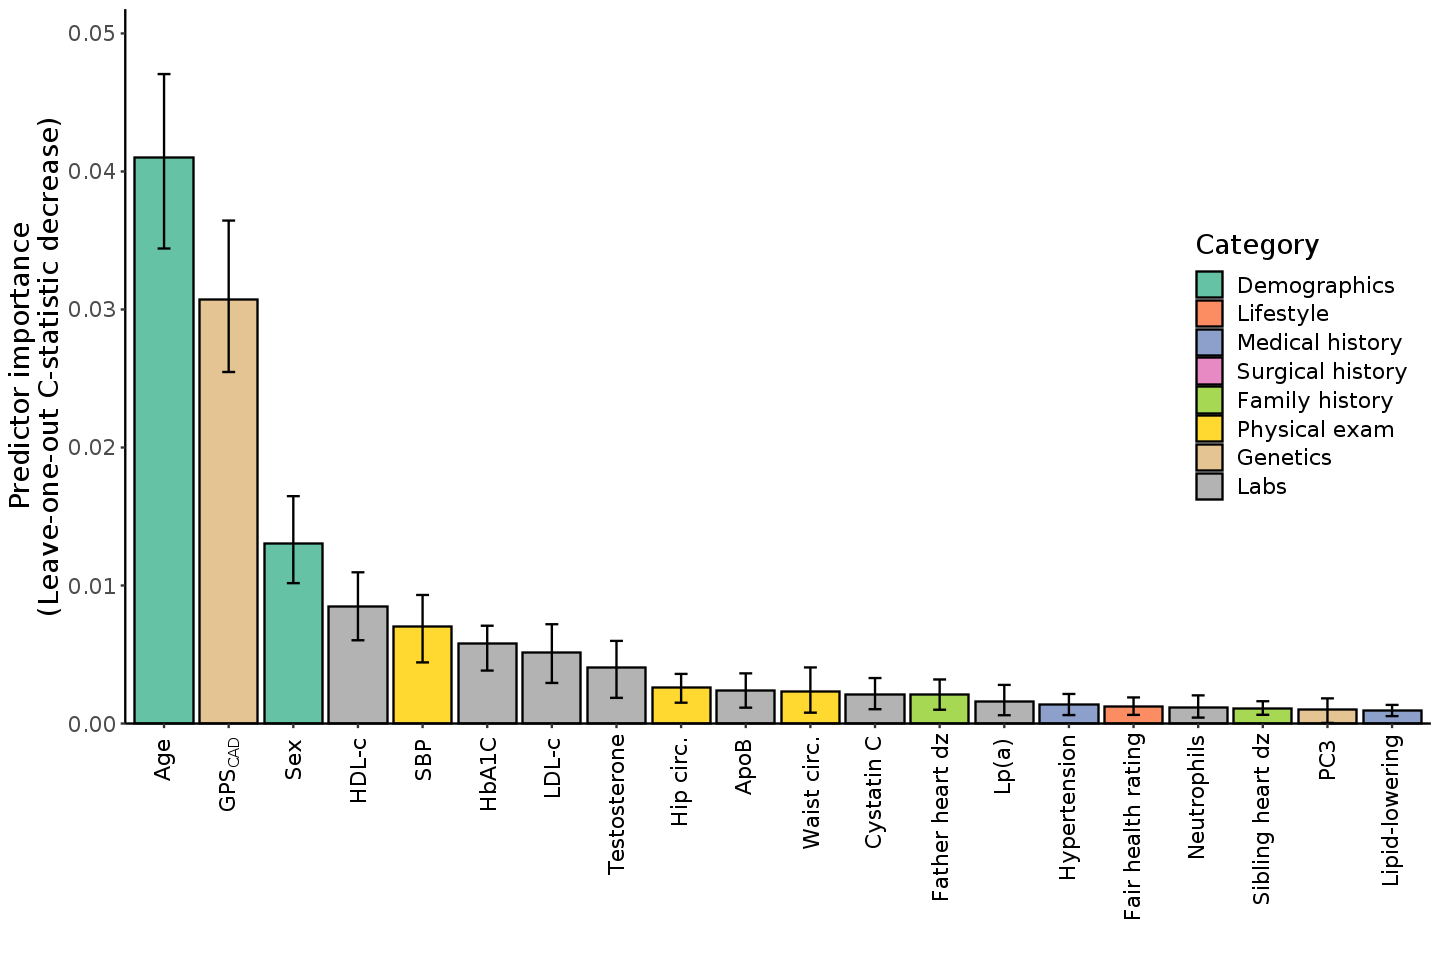

In [35]:
options(repr.plot.width=12,repr.plot.height=8)

featplot <- ggplot(coxnet_perm_merged[1:20],aes(x=reorder(human,-V1),y=V1,fill=category)) +
geom_bar(stat="identity",color="black") +
geom_errorbar(aes(ymin=V2,ymax=V3),width=0.2) +
xlab("") +
ylab("Predictor importance\n(Leave-one-out C-statistic decrease)") +
labs(fill='Category') +
theme_classic() + 
theme(axis.text.x = element_text(angle=90,hjust=0.95,vjust=0.5,color='black'),text = element_text(size=16,color='black'),
     legend.position=c(0.9,0.5)) +
# scale_fill_discrete(drop=FALSE) +
scale_fill_brewer(palette = 'Set2',drop=FALSE) +
scale_y_continuous(expand=expansion(mult = c(0,0.1))) + 
scale_x_discrete(breaks=coxnet_perm_merged[1:20]$human,
                labels=c('Age',expression(GPS[CAD]),'Sex','HDL-c','SBP','HbA1C',
                         'LDL-c','Testosterone','Hip circ.','ApoB','Waist circ.',
                         'Cystatin C','Father heart dz','Lp(a)','Hypertension',
                         'Fair health rating','Neutrophils','Sibling heart dz',
                         'PC3','Lipid-lowering'))
#the drop=FALSE allows all categories to remain even though I subsetting the datatable

featplot

# ggsave('coxnet51_leave1out.pdf',g2,width=10,height=8)

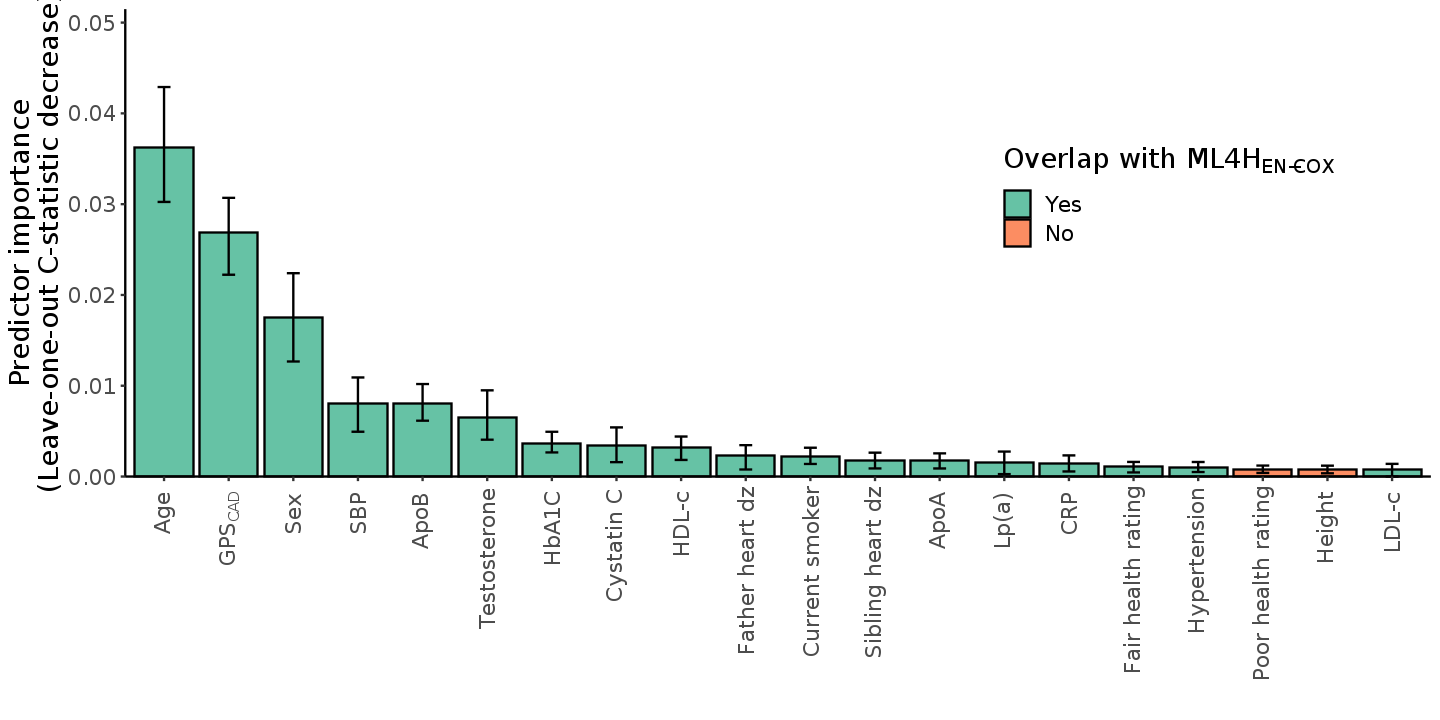

In [36]:
###Feat plot for xgcox

options(repr.plot.width=12,repr.plot.height=6)

xgCoxFeatPlot <- ggplot(xgcoxLeave1OutLabel[1:20],aes(x=reorder(abbrev,-mean),y=mean,fill=factor(overlap,levels=c(1,0),ordered=TRUE,labels=c('Yes','No')))) +
geom_bar(stat="identity",color="black") +
geom_errorbar(aes(ymin=lower,ymax=upper),width=0.2) +
xlab("") +
ylab("Predictor importance\n(Leave-one-out C-statistic decrease)") +
labs(fill=expression(Overlap~with~ML4H[EN-COX])) +
theme_classic() + 
theme(axis.text.x = element_text(angle=90,hjust=0.95,vjust=0.5),text = element_text(size=16),
     legend.position=c(0.8,0.6)) +
# scale_fill_discrete(drop=FALSE) +
scale_fill_brewer(palette = 'Set2',drop=FALSE) +
scale_y_continuous(expand=expansion(mult = c(0,0.2))) +
scale_x_discrete(breaks=xgcoxLeave1OutLabel[1:20]$abbrev,
                labels=c('Age',expression(GPS[CAD]),'Sex','SBP','ApoB','Testosterone',
                         'HbA1C','Cystatin C','HDL-c','Father heart dz','Current smoker',
                         'Sibling heart dz','ApoA','Lp(a)','CRP','Fair health rating',
                         'Hypertension','Poor health rating','Height','LDL-c'))
#the drop=FALSE allows all categories to remain even though I subsetting the datatable

xgCoxFeatPlot

# ggsave('coxnet51_leave1out.pdf',g2,width=10,height=8)

## Will use some of the above datatables to also make a correlation plot between all 51 features in the development set ordered by (1) category and (2) descending leave 1 out AUC.

In [37]:
coxnet_perm_imp_clean_corrplot <- coxnet_perm_imp_clean[field %in% coxnet_feature_list_annot_clean$field]

In [38]:
corrplot_dt <- merge(coxnet_feature_list_annot_clean,
                     coxnet_perm_imp_clean_corrplot[,c('field','V1')],
                    by='field',all=TRUE)

In [39]:
corrplot_dt[is.na(V1),V1:=0]

In [40]:
corrplot_dt <- corrplot_dt[order(-V1)]
corrplot_dt <- corrplot_dt[order(category)]

In [41]:
fullfeat_dev_corrplot <- setcolorder(fullfeat_devUnscaled,c('index',corrplot_dt$field))


In [42]:
names(fullfeat_dev_corrplot)[-1] <- corrplot_dt$abbrev

In [43]:
M <- cor(fullfeat_dev_corrplot[,-c('index')])

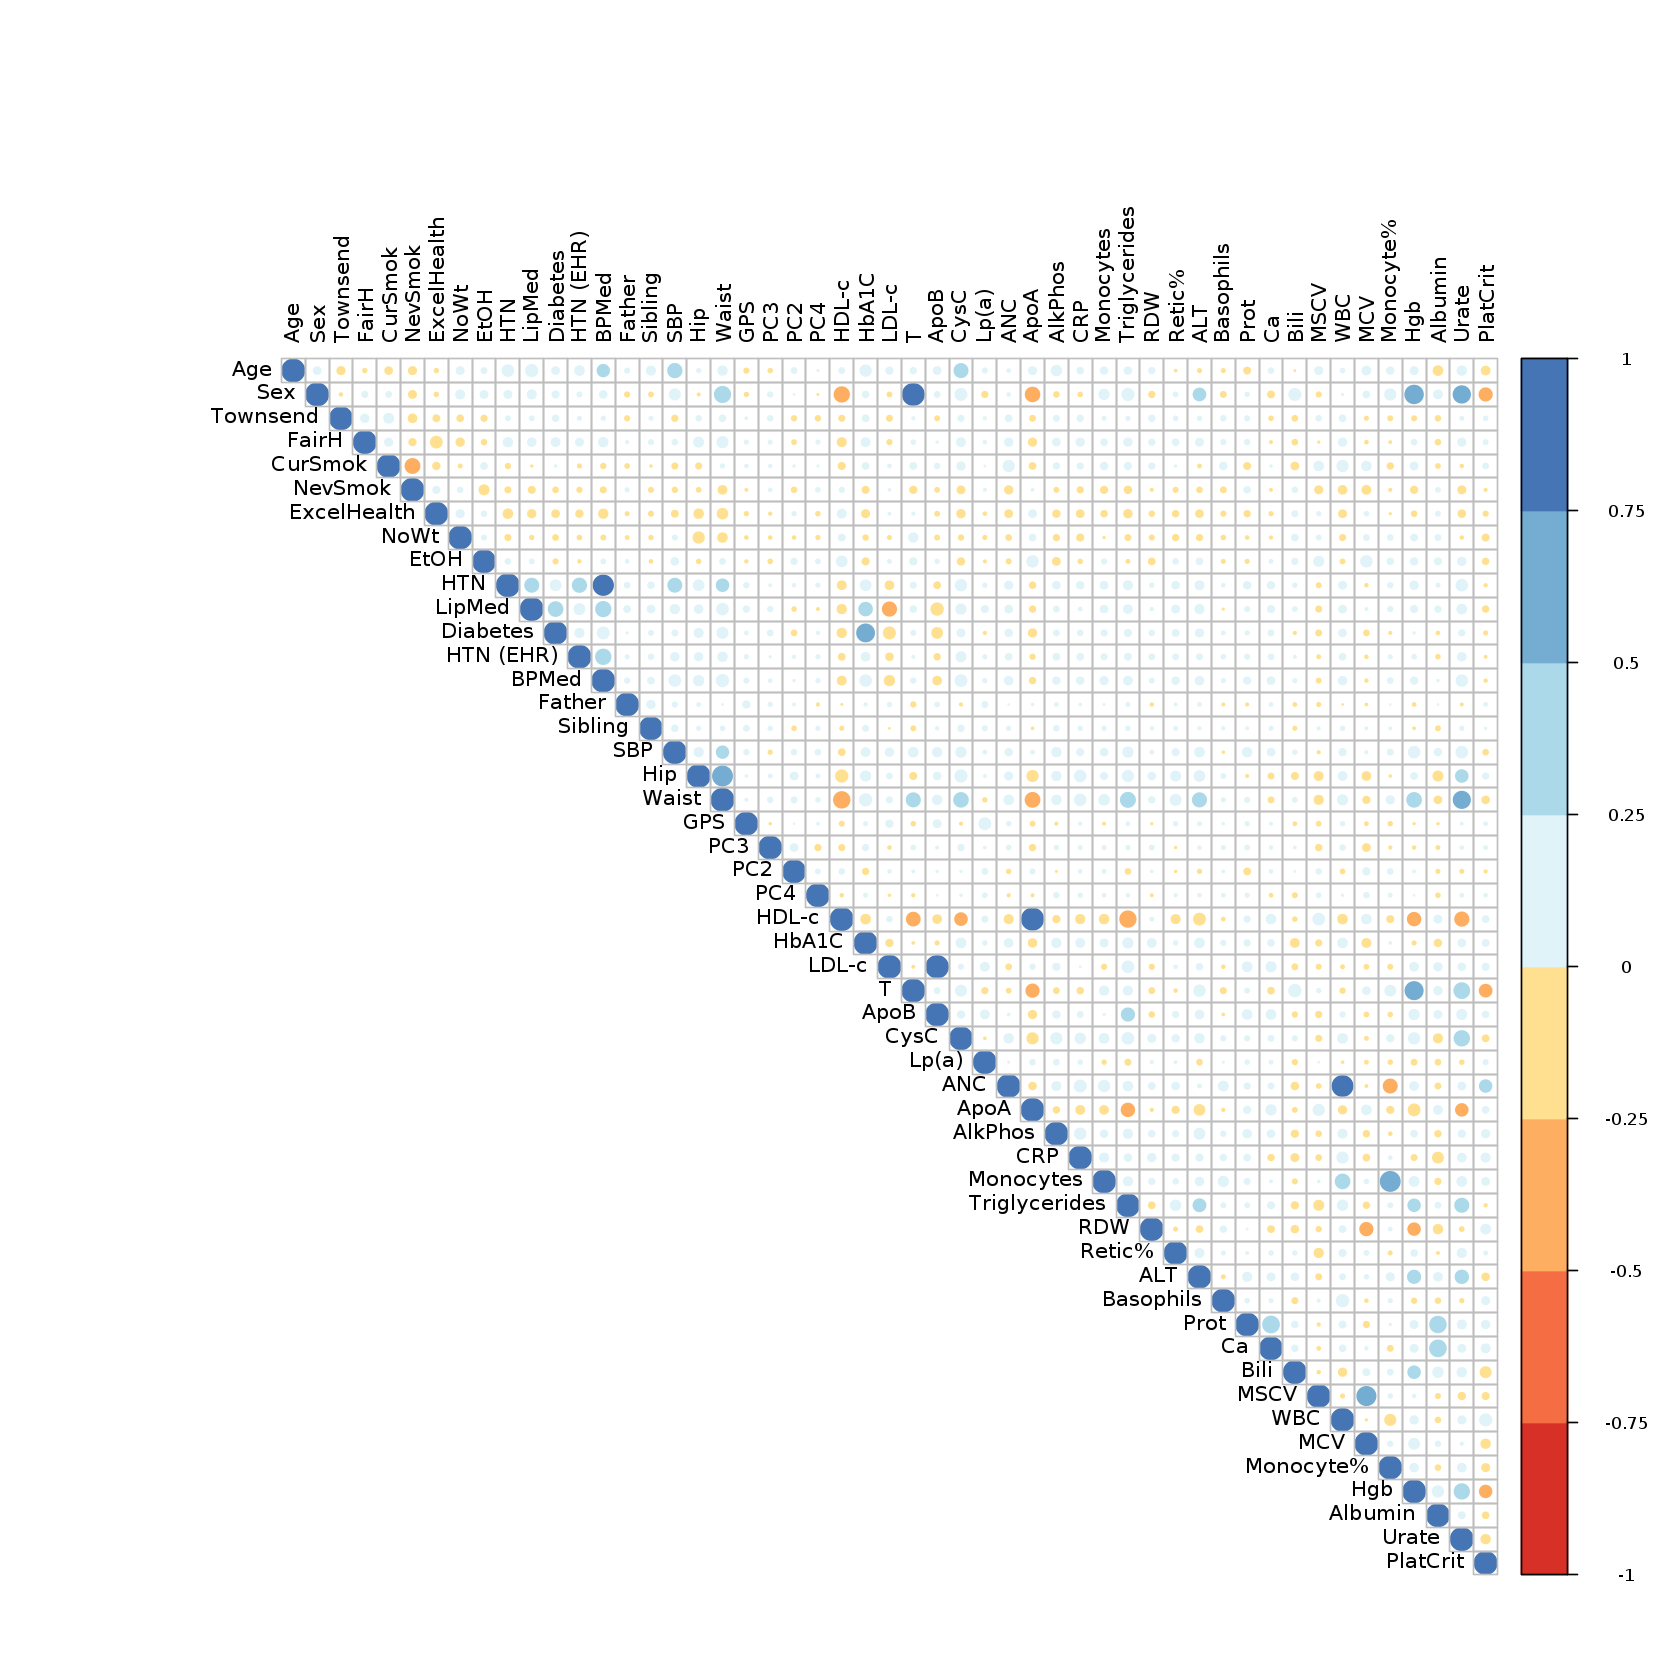

In [44]:
options(repr.plot.width=14,repr.plot.height=14)
corrplot(M,type='upper',order='original',col=brewer.pal(n=8,name='RdYlBu'),
         tl.col='black')

In [45]:
# pdf(height=16,width=16,file='/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/efigure6.pdf')

# corrplot(M,type='upper',order='original',col=brewer.pal(n=8,name='RdYlBu'),
#          tl.col='black')

# dev.off()

# Part 4: Building simple Cox proportional hazards model in the development cohort with either the 51 selected features or the top 20 features

In [46]:
fullfeat_dev <- fread("coxnet__feature_matrix__development_0_0011765691116882482__30Nov_2020.txt")
fullfeat_ho <- fread("coxnet__feature_matrix__holdout_0_0011765691116882482__30Nov_2020.txt")

In [48]:
dev_merged <- merge(fullfeat_dev,masterdf[,c('eid','CAD_incident_disease','CAD_fu_days')],
                   by.x='index',by.y='eid')

In [50]:
simplecox_cph <- coxph(Surv(CAD_fu_days,CAD_incident_disease) ~ ., data=dev_merged[,-c('index')])
summary(simplecox_cph)

Call:
coxph(formula = Surv(CAD_fu_days, CAD_incident_disease) ~ ., 
    data = dev_merged[, -c("index")])

  n= 138611, number of events= 4103 
   (8 observations deleted due to missingness)

                                        coef  exp(coef)   se(coef)      z
c_sex                              9.051e-01  2.472e+00  8.009e-02 11.301
c_antihypertensive                -2.683e-03  9.973e-01  5.625e-02 -0.048
c_lipidlowering                    2.056e-01  1.228e+00  4.875e-02  4.218
c_diabetes                         3.687e-01  1.446e+00  7.075e-02  5.212
c_smoking_0                       -1.037e-01  9.015e-01  3.510e-02 -2.955
c_smoking_2                        2.477e-01  1.281e+00  5.133e-02  4.826
c_weight_change_0                 -1.112e-01  8.948e-01  3.275e-02 -3.394
c_overall_health_1                -1.406e-01  8.688e-01  5.006e-02 -2.809
c_overall_health_3                 1.682e-01  1.183e+00  3.761e-02  4.472
father_1TRUE                       2.605e-01  1.298e+00  3.332e-02  

In [51]:
simplecox_cph_20 <- coxph(Surv(CAD_fu_days,CAD_incident_disease) ~ d_age +
                          d_prsadjscore + c_sex + d_biochemistry_30760 +
                          d_systolic_bp + d_biochemistry_30750 +
                          d_biochemistry_30780 + d_biochemistry_30850 +
                          d_hip + d_biochemistry_30640 +
                          d_waist + father_1 + d_biochemistry_30720 +
                          d_lipoprotein_a + c_selfreport_icd10_20002_1065 +
                          c_overall_health_3 + d_biochemistry_30140 +
                          sibling_1 + d_PC3 + c_lipidlowering, data=dev_merged)
summary(simplecox_cph_20)

Call:
coxph(formula = Surv(CAD_fu_days, CAD_incident_disease) ~ d_age + 
    d_prsadjscore + c_sex + d_biochemistry_30760 + d_systolic_bp + 
    d_biochemistry_30750 + d_biochemistry_30780 + d_biochemistry_30850 + 
    d_hip + d_biochemistry_30640 + d_waist + father_1 + d_biochemistry_30720 + 
    d_lipoprotein_a + c_selfreport_icd10_20002_1065 + c_overall_health_3 + 
    d_biochemistry_30140 + sibling_1 + d_PC3 + c_lipidlowering, 
    data = dev_merged)

  n= 138611, number of events= 4103 
   (8 observations deleted due to missingness)

                                       coef exp(coef)  se(coef)       z
d_age                              0.434907  1.544820  0.019559  22.236
d_prsadjscore                      0.334300  1.396962  0.016243  20.581
c_sex                              0.812036  2.252489  0.075332  10.779
d_biochemistry_30760              -0.234084  0.791295  0.022867 -10.237
d_systolic_bp                      0.177717  1.194487  0.016539  10.745
d_biochemistry_30750   

# Part 5: Developing a datatable with all predictors, absolute risk predictions for all models and outcomes. With this, can generate all sorts of discrimination, calibration, reclassification figures that will go in main text/SI.

In [52]:
fullfeat_dev <- fread("coxnet__feature_matrix__development_0_0011765691116882482__30Nov_2020.txt")
fullfeat_ho <- fread("coxnet__feature_matrix__holdout_0_0011765691116882482__30Nov_2020.txt")

In [53]:
masterdf_dev1_pred <- masterdf[subgroup_indicator == 1]
masterdf_ho1_pred <- masterdf[subgroup_indicator == 2]
masterdf_devho1_pred <- masterdf[subgroup_indicator != 0]

## Recalibrating PCE and QRISK3 to these incidences (using EHJ 2019 methodology)

In [54]:
tfunc <- function(vec){
        vec2 <- log(-1*log(1-vec))
        return(vec2)
    }

In [55]:
undo_func <- function(vec){
    vec2 <- 1 - (exp(-1*exp(vec)))
    return(vec2)
}

In [56]:
EHJ2019Cox <- coxph(Surv(CAD_fu_days,CAD_incident_disease) ~ ageG2 + ageG3 + ageG4 + ageG5 + ageG6 + ageG7,
                    data=masterdf_dev1_pred[sex == 'Male'])

EHJ2019Cox_10yr <- coxph(Surv(CAD_fu_days10yr,CAD_tenyearoutcome) ~ ageG2 + ageG3 + ageG4 + ageG5 + ageG6 + ageG7,
                    data=masterdf_dev1_pred[sex == 'Male'])

EHJ2019CoxF <- coxph(Surv(CAD_fu_days,CAD_incident_disease) ~ ageG2 + ageG3 + ageG4 + ageG5 + ageG6 + ageG7,
                    data=masterdf_dev1_pred[sex == 'Female'])

EHJ2019Cox_10yrF <- coxph(Surv(CAD_fu_days10yr,CAD_tenyearoutcome) ~ ageG2 + ageG3 + ageG4 + ageG5 + ageG6 + ageG7,
                    data=masterdf_dev1_pred[sex == 'Female'])

dummyDT <- data.table(ageG1 = c(1,rep(0,6)),
                     ageG2 = c(0,1,rep(0,5)),
                      ageG3 = c(0,0,1,rep(0,4)),
                      ageG4 = c(0,0,0,1,0,0,0),
                      ageG5 = c(rep(0,4),1,0,0),
                      ageG6 = c(rep(0,5),1,0),
                      ageG7 = c(rep(0,6),1))

MalePred <- absolute_risk(EHJ2019Cox,dummyDT)

FemalePred <- absolute_risk(EHJ2019CoxF,dummyDT)

[1] "S_o(10) = 0.964"
[1] "S_o(10) = 0.991"


In [57]:
ext_cal_mod <- function(dt_in,predcol,sortcol,extpred){
    intpred <- 
    tapply(dt_in[[predcol]],dt_in[[sortcol]],mean)
    
    dt <- as.data.table(cbind(intpred,extpred))
    names(dt) <- c("intpred","extpred")
    
    lm1 <- lm(tfunc(extpred) ~ tfunc(intpred),data = dt)
    return(lm1)
}

In [58]:
##Note that the requirement to make sure tenyearASCVD or qrisk3 are not missing
##omits 9 entries for former and 6-7% entries for latter.

PCE_recal_male <- ext_cal_mod(masterdf_dev1_pred[sex=='Male' & !is.na(tenyearASCVD)],"tenyearASCVD","age_group",MalePred)
PCE_recal_female <- ext_cal_mod(masterdf_dev1_pred[sex=='Female' & !is.na(tenyearASCVD)],"tenyearASCVD","age_group",FemalePred)

QRISK3_recal_male <- ext_cal_mod(masterdf_dev1_pred[sex=='Male' & !is.na(qrisk3)],"qrisk3","age_group",MalePred)
QRISK3_recal_female <- ext_cal_mod(masterdf_dev1_pred[sex=='Female' & !is.na(qrisk3)],"qrisk3","age_group",FemalePred)

fram_recal_male <- ext_cal_mod(masterdf_dev1_pred[sex=='Male' & !is.na(framrisk)],"framrisk","age_group",MalePred)
fram_recal_female <- ext_cal_mod(masterdf_dev1_pred[sex=='Female' & !is.na(framrisk)],"framrisk","age_group",FemalePred)

In [59]:
masterdf_ho1_pred[sex=='Male',tenyearASCVD_recal:=undo_func((tfunc(tenyearASCVD) * PCE_recal_male$coefficients[["tfunc(intpred)"]]) +
    PCE_recal_male$coefficients[["(Intercept)"]])]

masterdf_ho1_pred[sex=='Female',tenyearASCVD_recal:=undo_func((tfunc(tenyearASCVD) * PCE_recal_female$coefficients[["tfunc(intpred)"]]) +
    PCE_recal_female$coefficients[["(Intercept)"]])]

masterdf_dev1_pred[sex=='Male',tenyearASCVD_recal:=undo_func((tfunc(tenyearASCVD) * PCE_recal_male$coefficients[["tfunc(intpred)"]]) +
    PCE_recal_male$coefficients[["(Intercept)"]])]

masterdf_dev1_pred[sex=='Female',tenyearASCVD_recal:=undo_func((tfunc(tenyearASCVD) * PCE_recal_female$coefficients[["tfunc(intpred)"]]) +
    PCE_recal_female$coefficients[["(Intercept)"]])]

masterdf_devho1_pred[sex=='Male',tenyearASCVD_recal:=undo_func((tfunc(tenyearASCVD) * PCE_recal_male$coefficients[["tfunc(intpred)"]]) +
    PCE_recal_male$coefficients[["(Intercept)"]])]

masterdf_devho1_pred[sex=='Female',tenyearASCVD_recal:=undo_func((tfunc(tenyearASCVD) * PCE_recal_female$coefficients[["tfunc(intpred)"]]) +
    PCE_recal_female$coefficients[["(Intercept)"]])]

In [60]:
masterdf_ho1_pred[sex=='Male',qrisk3_recal:=undo_func((tfunc(qrisk3) * QRISK3_recal_male$coefficients[["tfunc(intpred)"]]) +
    QRISK3_recal_male$coefficients[["(Intercept)"]])]

masterdf_ho1_pred[sex=='Female',qrisk3_recal:=undo_func((tfunc(qrisk3) * QRISK3_recal_female$coefficients[["tfunc(intpred)"]]) +
    QRISK3_recal_female$coefficients[["(Intercept)"]])]

masterdf_dev1_pred[sex=='Male',qrisk3_recal:=undo_func((tfunc(qrisk3) * QRISK3_recal_male$coefficients[["tfunc(intpred)"]]) +
    QRISK3_recal_male$coefficients[["(Intercept)"]])]

masterdf_dev1_pred[sex=='Female',qrisk3_recal:=undo_func((tfunc(qrisk3) * QRISK3_recal_female$coefficients[["tfunc(intpred)"]]) +
    QRISK3_recal_female$coefficients[["(Intercept)"]])]

masterdf_devho1_pred[sex=='Male',qrisk3_recal:=undo_func((tfunc(qrisk3) * QRISK3_recal_male$coefficients[["tfunc(intpred)"]]) +
    QRISK3_recal_male$coefficients[["(Intercept)"]])]

masterdf_devho1_pred[sex=='Female',qrisk3_recal:=undo_func((tfunc(qrisk3) * QRISK3_recal_female$coefficients[["tfunc(intpred)"]]) +
    QRISK3_recal_female$coefficients[["(Intercept)"]])]

In [61]:
masterdf_ho1_pred[sex=='Male',framrisk_recal:=undo_func((tfunc(framrisk) * fram_recal_male$coefficients[["tfunc(intpred)"]]) +
    fram_recal_male$coefficients[["(Intercept)"]])]

masterdf_ho1_pred[sex=='Female',framrisk_recal:=undo_func((tfunc(framrisk) * fram_recal_female$coefficients[["tfunc(intpred)"]]) +
    fram_recal_female$coefficients[["(Intercept)"]])]

masterdf_dev1_pred[sex=='Male',framrisk_recal:=undo_func((tfunc(framrisk) * fram_recal_male$coefficients[["tfunc(intpred)"]]) +
    fram_recal_male$coefficients[["(Intercept)"]])]

masterdf_dev1_pred[sex=='Female',framrisk_recal:=undo_func((tfunc(framrisk) * fram_recal_female$coefficients[["tfunc(intpred)"]]) +
    fram_recal_female$coefficients[["(Intercept)"]])]

masterdf_devho1_pred[sex=='Male',framrisk_recal:=undo_func((tfunc(framrisk) * fram_recal_male$coefficients[["tfunc(intpred)"]]) +
    fram_recal_male$coefficients[["(Intercept)"]])]

masterdf_devho1_pred[sex=='Female',framrisk_recal:=undo_func((tfunc(framrisk) * fram_recal_female$coefficients[["tfunc(intpred)"]]) +
    fram_recal_female$coefficients[["(Intercept)"]])]

# Adding in predicted risk by ML4HEN-COX

In [62]:
coxnet_abs_id <- fread("coxnet__absolute_risk_with_ids__development_model_0_0011765691116882482__30Nov_2020.txt")
coxnet_abs_ho_id <- fread("coxnet__absolute_risk_with_ids__holdout_model_0_0011765691116882482__30Nov_2020.txt")

In [63]:
coxnet_abs_ho_id$coxnet51risk <- coxnet_abs_ho_id$abs_risk_t10
coxnet_abs_id$coxnet51risk <- coxnet_abs_id$abs_risk_t10

In [64]:
masterdf_ho1_pred1 <- merge(masterdf_ho1_pred,coxnet_abs_ho_id[,c('ukbid','coxnet51risk')],
                           by.x='eid',by.y='ukbid')

masterdf_dev1_pred1 <- merge(masterdf_dev1_pred,coxnet_abs_id[,c('ukbid','coxnet51risk')],
                           by.x='eid',by.y='ukbid')

# Adding in predicted risk by simple Cox model with 51 features and simple Cox model with top 20 features

In [65]:
simplecox_feat1 <- fread("coxph__feature_list_0_0011765691116882482__30Nov_2020.txt")
simplecox_feat1 <- simplecox_feat1[-1]

In [66]:
all.equal(simplecox_feat1$V1,names(fullfeat_dev[,-c('index')]))

[1] TRUE

In [67]:
featurenames_simplecox <- names(fullfeat_dev[,-c('index')])

In [68]:
simplecox_newlp_dev <- fullfeat_dev[,Calc := as.matrix(fullfeat_dev[,..featurenames_simplecox])%*%simplecox_feat1$V2]
simplecox_newlp_ho <- fullfeat_ho[,Calc := as.matrix(fullfeat_ho[,..featurenames_simplecox])%*%simplecox_feat1$V2]

Warning message in `[.data.table`(fullfeat_dev, , ..featurenames_simplecox):
"Both 'featurenames_simplecox' and '..featurenames_simplecox' exist in calling scope. Please remove the '..featurenames_simplecox' variable in calling scope for clarity."
Warning message in `[.data.table`(fullfeat_ho, , ..featurenames_simplecox):
"Both 'featurenames_simplecox' and '..featurenames_simplecox' exist in calling scope. Please remove the '..featurenames_simplecox' variable in calling scope for clarity."


In [69]:
coxnet_abs_id$simplecox_newlp <- simplecox_newlp_dev$Calc
coxnet_abs_ho_id$simplecox_newlp <- simplecox_newlp_ho$Calc

In [70]:
cph_simplecox_dev <- coxph(Surv(time,O) ~ simplecox_newlp,data=coxnet_abs_id)
cumhaz5 <- basehaz(cph_simplecox_dev,centered = TRUE)
basesurv10_5 <- exp(-1*cumhaz5$hazard[which.min(abs(cumhaz5$time - 3652))])
coxnet_abs_ho_id$simpcox51risk <- 1 - basesurv10_5^exp((coxnet_abs_ho_id$simplecox_newlp - mean(coxnet_abs_id$simplecox_newlp)))
coxnet_abs_id$simpcox51risk <- 1 - basesurv10_5^exp((coxnet_abs_id$simplecox_newlp - mean(coxnet_abs_id$simplecox_newlp)))

In [71]:
coxnet_abs_ho_id$simpcox20risk <- absolute_risk(simplecox_cph_20,data=fullfeat_ho)
coxnet_abs_id$simpcox20risk <- absolute_risk(simplecox_cph_20,data=fullfeat_dev)

[1] "S_o(10) = 0.985"
[1] "S_o(10) = 0.985"


In [72]:
masterdf_ho1_pred2 <- merge(masterdf_ho1_pred1,coxnet_abs_ho_id[,c('ukbid','simpcox51risk','simpcox20risk')],
                           by.x='eid',by.y='ukbid')

masterdf_dev1_pred2 <- merge(masterdf_dev1_pred1,coxnet_abs_id[,c('ukbid','simpcox51risk','simpcox20risk')],
                           by.x='eid',by.y='ukbid')

## Adding in XgCox risk

In [73]:
xgcoxAbsRiskHo_clean <- xgcoxAbsRiskHo[,c('ukbid','abs_risk_t10')]
names(xgcoxAbsRiskHo_clean)[2] <- 'xgcoxrisk'

masterdf_ho1_pred2 <- merge(masterdf_ho1_pred2,xgcoxAbsRiskHo_clean,by.x='eid',by.y='ukbid')

## Correlation plot

In [74]:
dtforcorrEFig9 <- masterdf_ho1_pred2[,c('coxnet51risk','simpcox51risk','xgcoxrisk',
                                   'framrisk_recal','tenyearASCVD_recal','qrisk3_recal')]

In [75]:
names(dtforcorrEFig9) <- c('ML4HEN-COX','SimpleCox51','XGBoost','FRS','PCE','QRISK3')

In [76]:
M4 <- cor(dtforcorrEFig9,use = 'complete.obs')
M4

,ML4HEN-COX,SimpleCox51,XGBoost,FRS,PCE,QRISK3
ML4HEN-COX,1.0000000,0.9573876,0.9090484,0.7488381,0.7534904,0.7700297
SimpleCox51,0.9573876,1.0000000,0.9253971,0.7215648,0.7350300,0.7684610
XGBoost,0.9090484,0.9253971,1.0000000,0.7242958,0.7322608,0.7571263
FRS,0.7488381,0.7215648,0.7242958,1.0000000,0.9317569,0.8589447
PCE,0.7534904,0.7350300,0.7322608,0.9317569,1.0000000,0.9200418
QRISK3,0.7700297,0.7684610,0.7571263,0.8589447,0.9200418,1.0000000


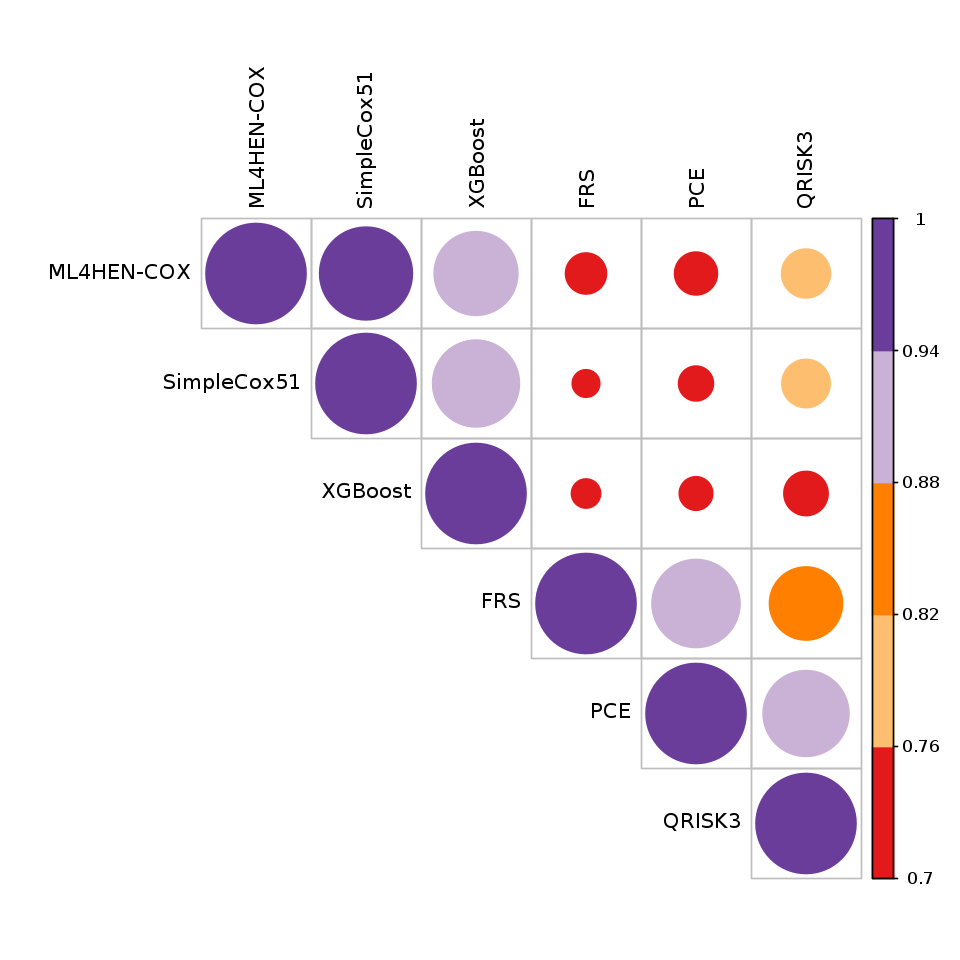

In [77]:
# pdf(height=8,width=8,file='/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/efigure9.pdf')
options(repr.plot.width=8,repr.plot.height=8)
corrplot(M4,type='upper',order='original',col=brewer.pal(n=10,name='Paired'),
         tl.col='black',cl.lim=c(0.7,1),is.corr=FALSE)

# dev.off()

# Making calibration plots

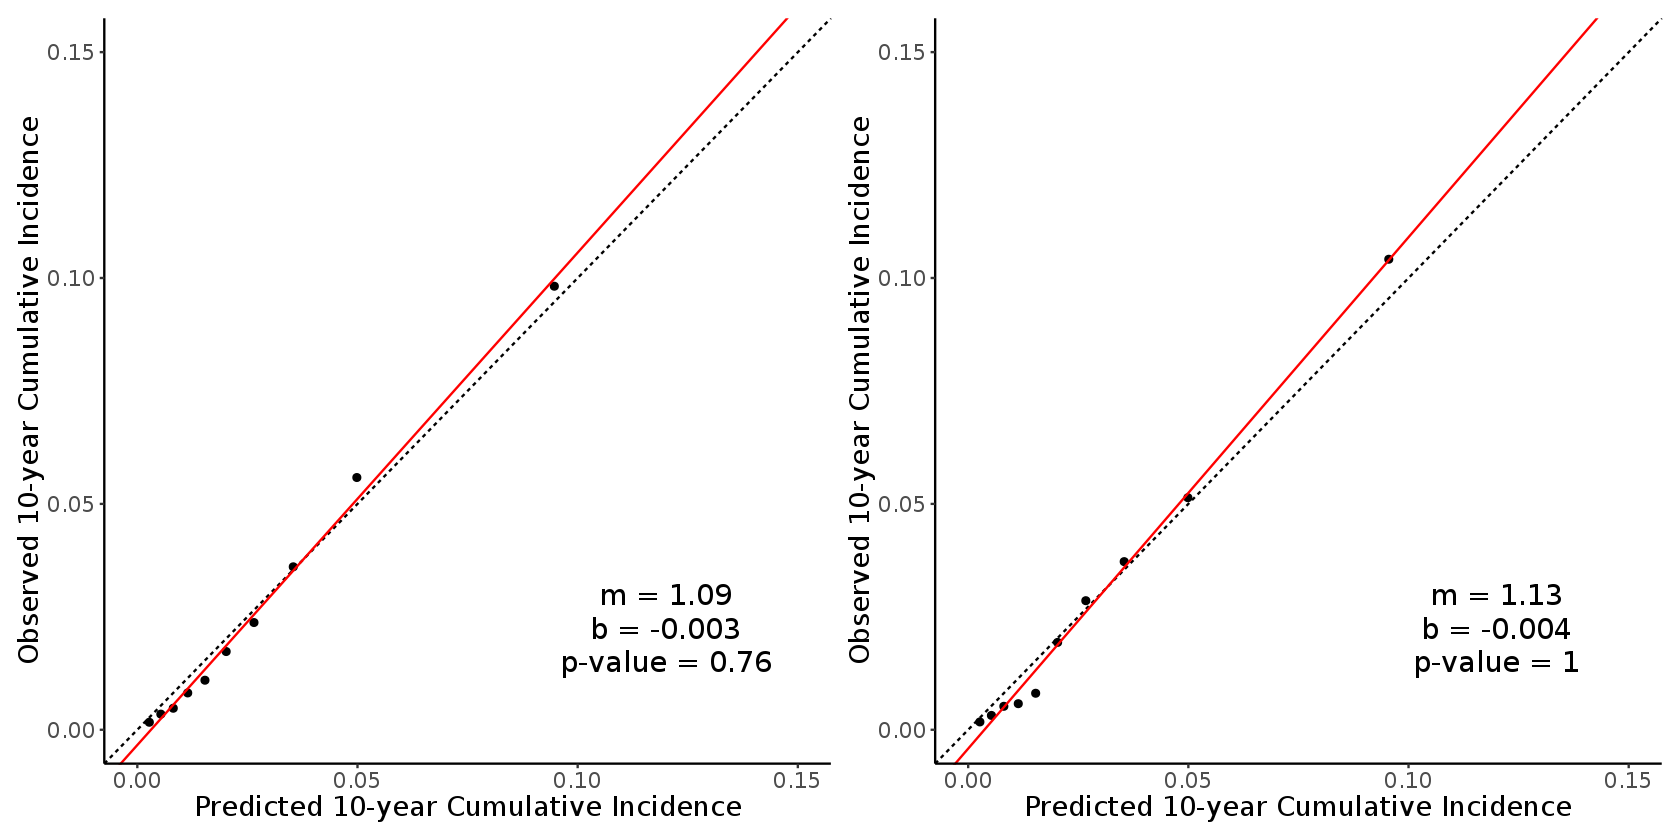

In [118]:
options(repr.plot.width=14,repr.plot.height=7)

coxnet51_cal_dev <- calibration_plot(data=masterdf_dev1_pred2,
                predictioncol='coxnet51risk',
                eventcol='CAD_tenyearoutcome')

coxnet51_cal_ho <- calibration_plot(data=masterdf_ho1_pred2,
                predictioncol='coxnet51risk',
                eventcol='CAD_tenyearoutcome')

coxnet_cal <- coxnet51_cal_dev + coxnet51_cal_ho + plot_layout(nrow=1)
coxnet_cal

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/efigure4_alt.pdf',
#        coxnet_cal,width=14,height=7)

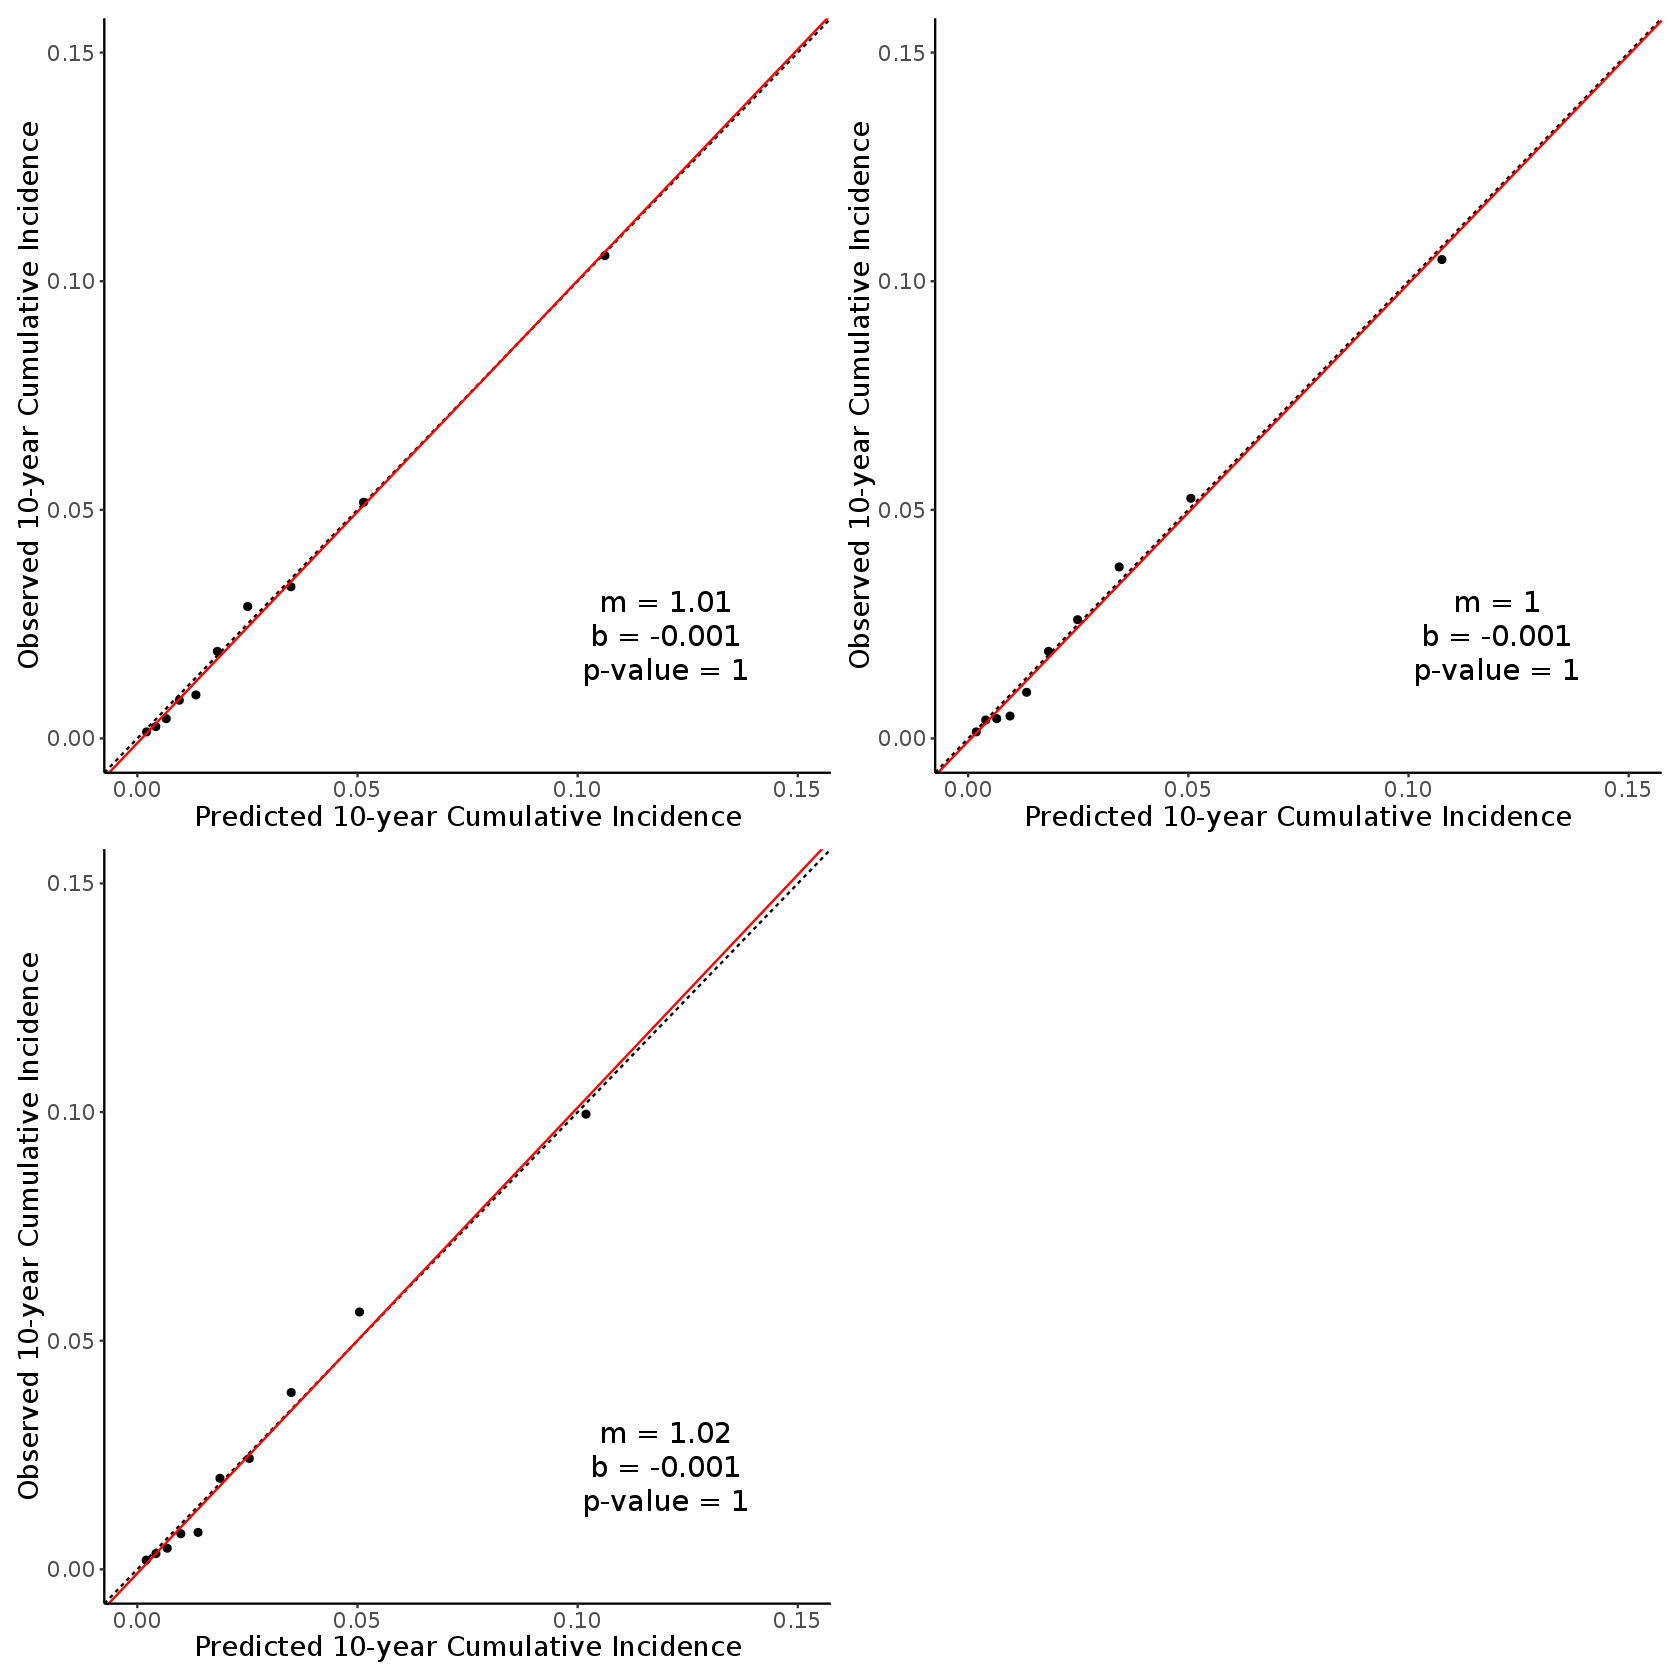

In [119]:
options(repr.plot.width=14,repr.plot.height=14)

xgboost_cal_ho <- calibration_plot(data=masterdf_ho1_pred2,
                predictioncol='xgcoxrisk',
                eventcol='CAD_tenyearoutcome')

simpcox51_cal_ho <- calibration_plot(data=masterdf_ho1_pred2,
                predictioncol='simpcox51risk',
                eventcol='CAD_tenyearoutcome')

simpcox20_cal_ho <- calibration_plot(data=masterdf_ho1_pred2,
                predictioncol='simpcox20risk',
                eventcol='CAD_tenyearoutcome')

SnAnalysis_cal <- xgboost_cal_ho + simpcox51_cal_ho + simpcox20_cal_ho + plot_layout(nrow=2,ncol=2)
SnAnalysis_cal

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/efigure5_alt.pdf',
#        SnAnalysis_cal,width=14,height=14)

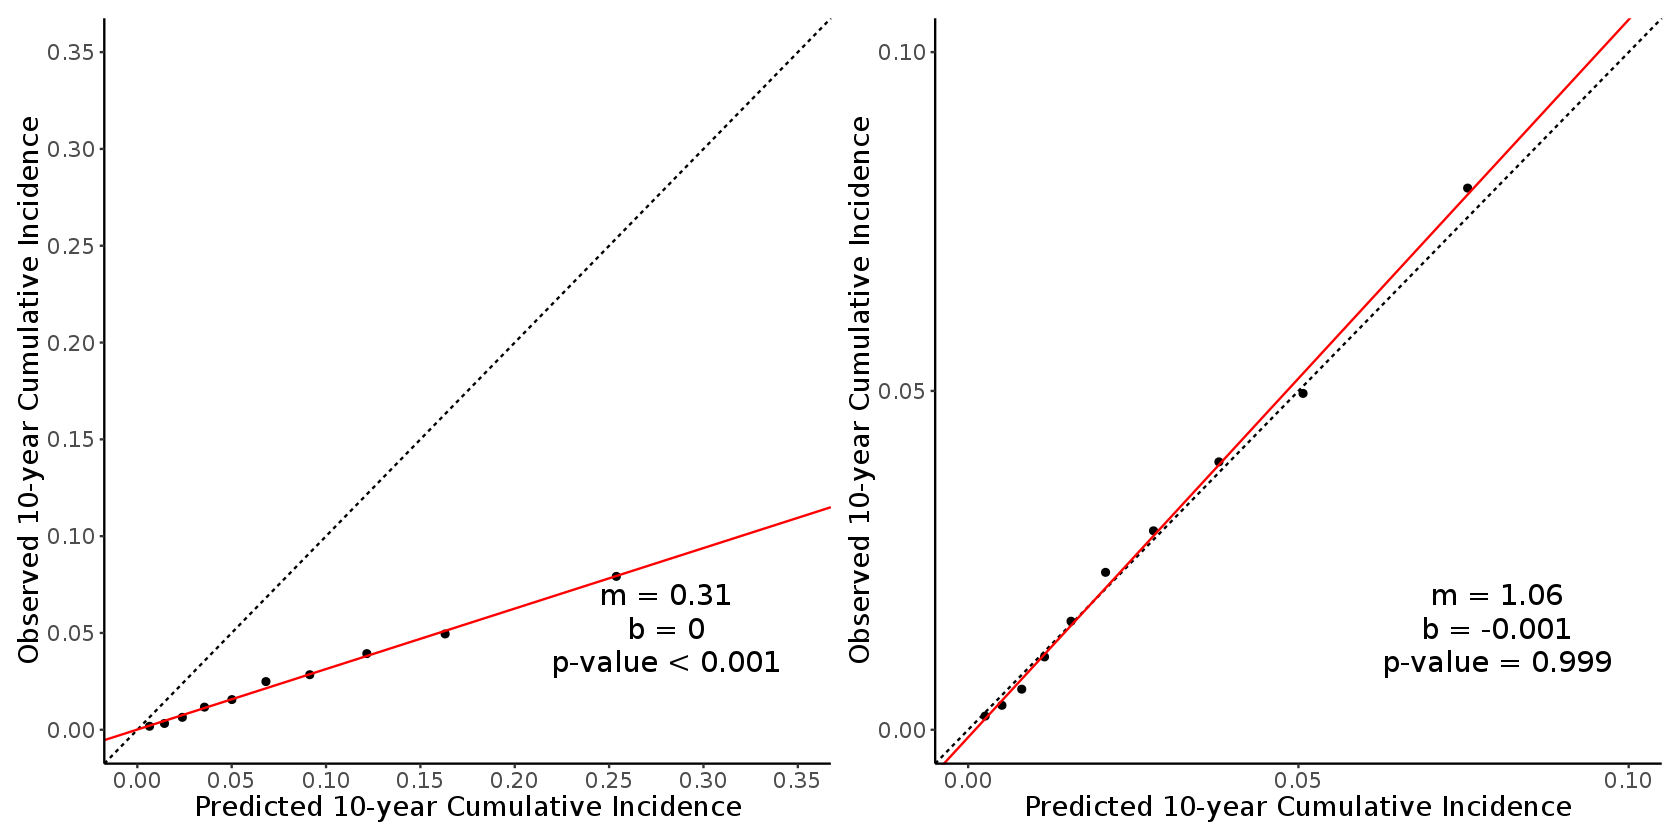

In [120]:
options(repr.plot.width=14,repr.plot.height=7)

pce_cal_dev <- calibration_plot(data=masterdf_dev1_pred[!is.na(tenyearASCVD)],
                predictioncol='tenyearASCVD',
                eventcol='CAD_tenyearoutcome',
                manualpvalue='p-value < 0.001')

pce_recal_cal_dev <- calibration_plot(data=masterdf_dev1_pred[!is.na(tenyearASCVD)],
                predictioncol='tenyearASCVD_recal',
                eventcol='CAD_tenyearoutcome')

pce_plots_dev <- pce_cal_dev + pce_recal_cal_dev 
pce_plots_dev

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/pce_calplots_dev.pdf',
#        pce_plots_dev,width=14,height=7)

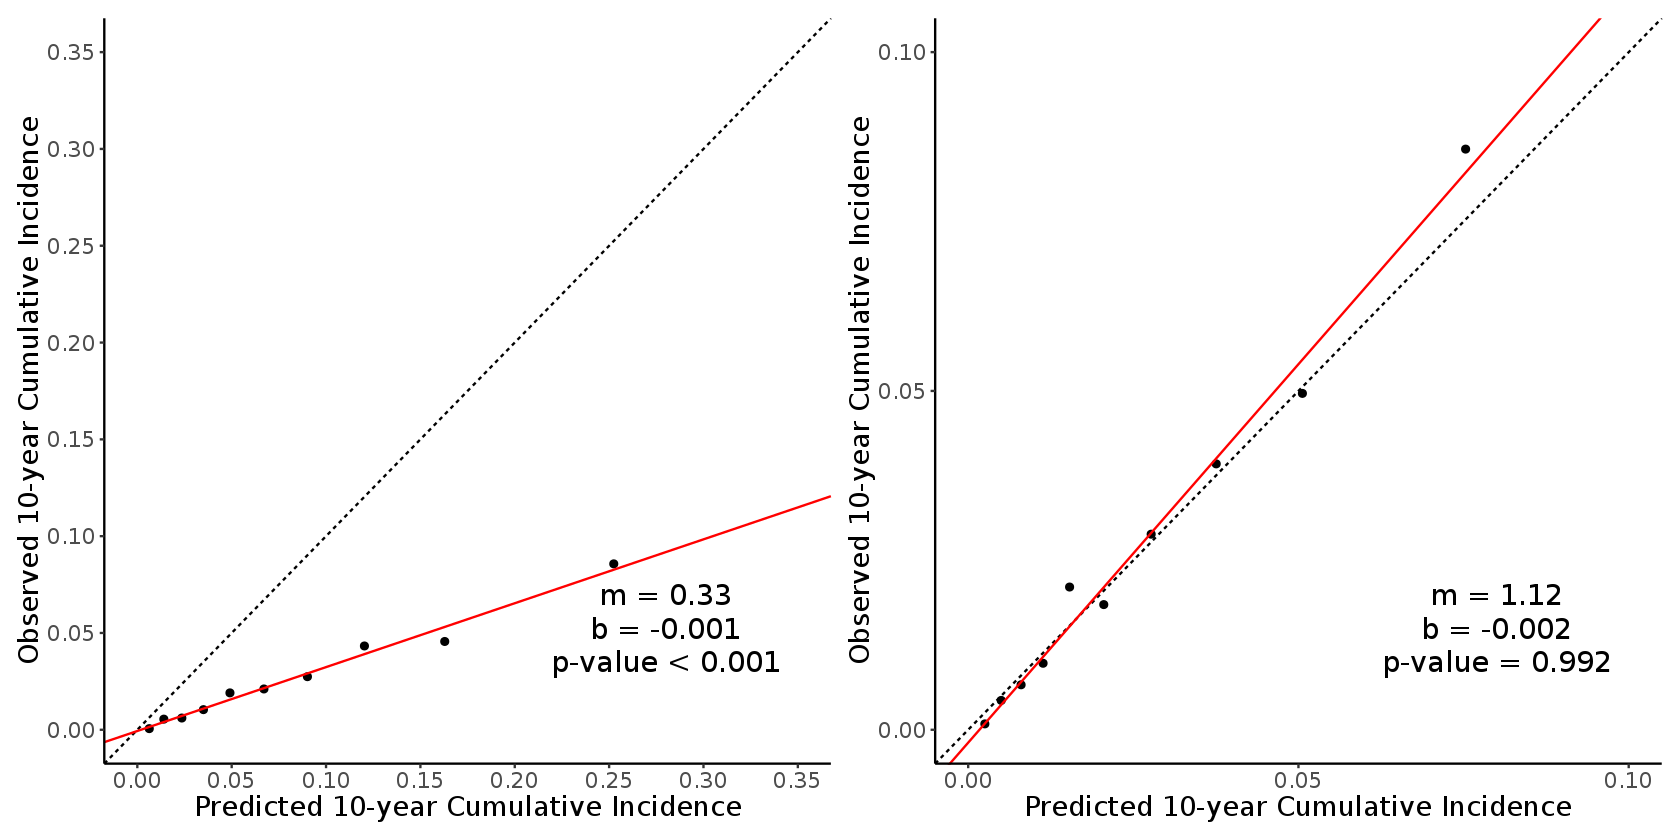

In [121]:
options(repr.plot.width=14,repr.plot.height=7)

pce_cal_ho <- calibration_plot(data=masterdf_ho1_pred[!is.na(tenyearASCVD)],
                predictioncol='tenyearASCVD',
                eventcol='CAD_tenyearoutcome',
                manualpvalue='p-value < 0.001')

pce_recal_cal_ho <- calibration_plot(data=masterdf_ho1_pred[!is.na(tenyearASCVD)],
                predictioncol='tenyearASCVD_recal',
                eventcol='CAD_tenyearoutcome')

pce_plots_ho <- pce_cal_ho + pce_recal_cal_ho 
pce_plots_ho

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/pce_calplots.pdf',
#        pce_plots,width=14,height=7)

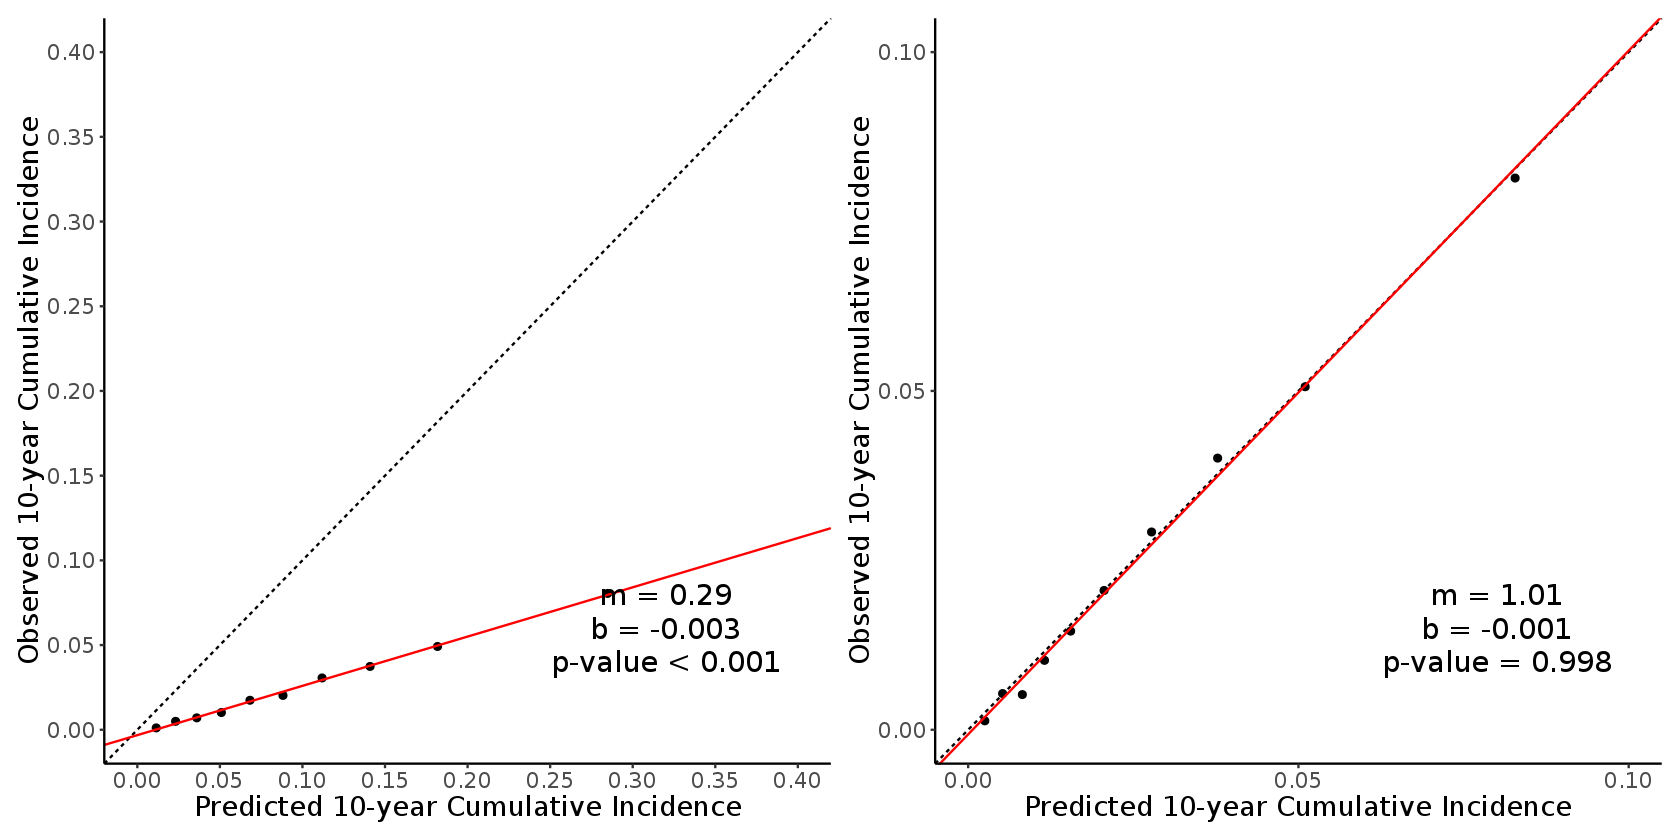

In [122]:
options(repr.plot.width=14,repr.plot.height=7)

qrisk3_cal_dev <- calibration_plot(data=masterdf_dev1_pred[!is.na(qrisk3)],
                predictioncol='qrisk3',
                eventcol='CAD_tenyearoutcome',
                manualpvalue='p-value < 0.001')

qrisk3_recal_cal_dev <- calibration_plot(data=masterdf_dev1_pred[!is.na(qrisk3_recal)],
                predictioncol='qrisk3_recal',
                eventcol='CAD_tenyearoutcome')

qrisk3_plots_dev <- qrisk3_cal_dev + qrisk3_recal_cal_dev
qrisk3_plots_dev

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/qrisk3_calplots_dev.pdf',
#        qrisk3_plots_dev,width=14,height=7)

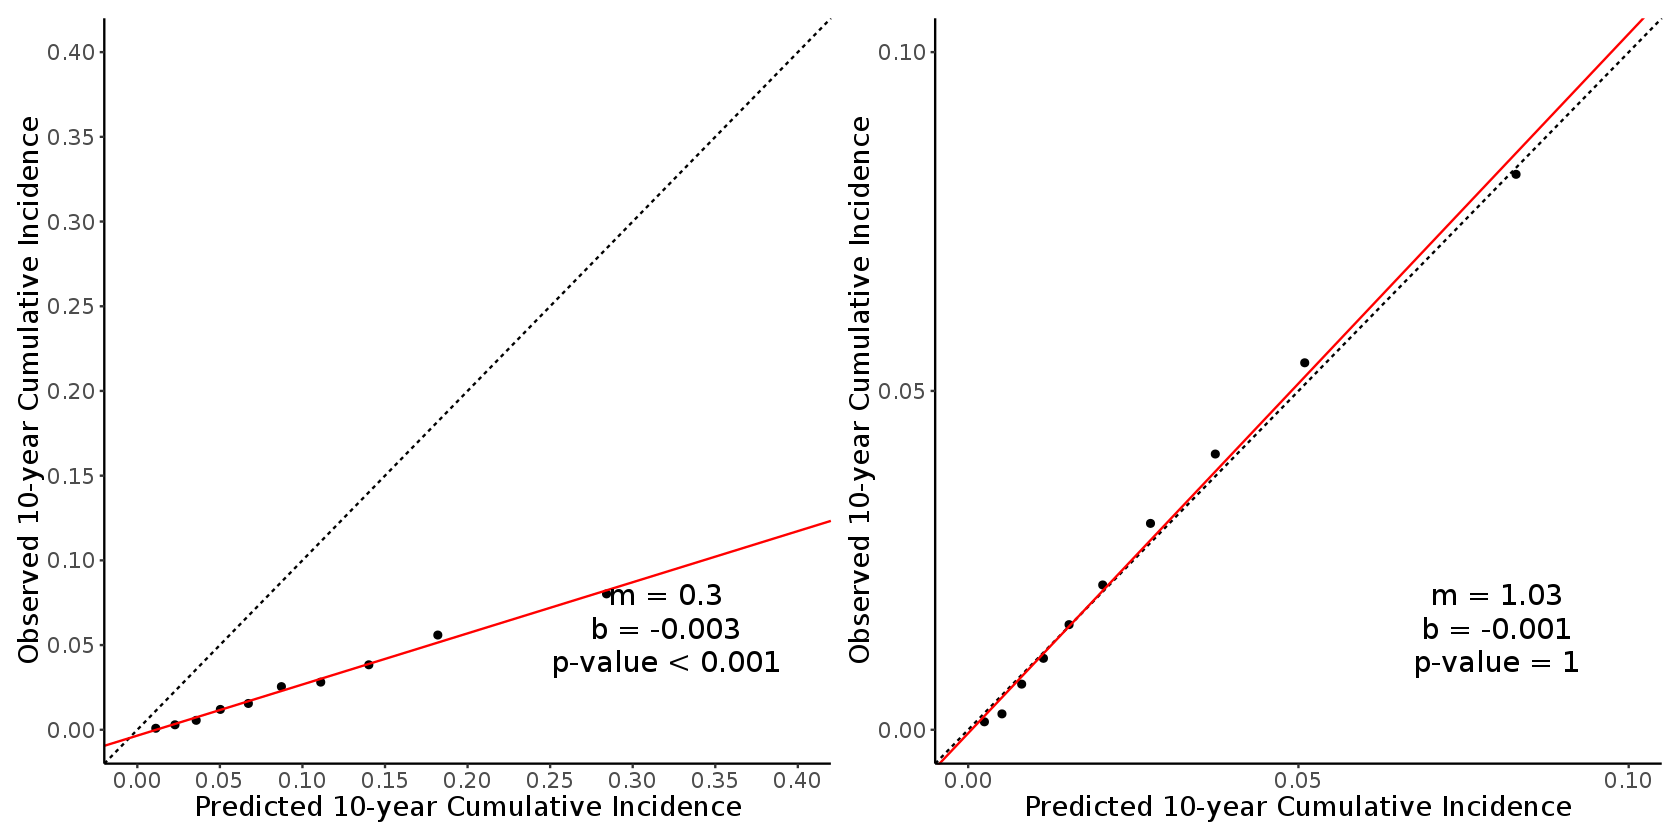

In [124]:
options(repr.plot.width=14,repr.plot.height=7)

qrisk3_cal_ho <- calibration_plot(data=masterdf_ho1_pred[!is.na(qrisk3)],
                predictioncol='qrisk3',
                eventcol='CAD_tenyearoutcome',
                manualpvalue='p-value < 0.001')

qrisk3_recal_cal_ho <- calibration_plot(data=masterdf_ho1_pred[!is.na(qrisk3_recal)],
                predictioncol='qrisk3_recal',
                eventcol='CAD_tenyearoutcome')

qrisk3_plots_ho <- qrisk3_cal_ho + qrisk3_recal_cal_ho
qrisk3_plots_ho

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/qrisk3_calplots.pdf',
#        qrisk3_plots,width=14,height=7)

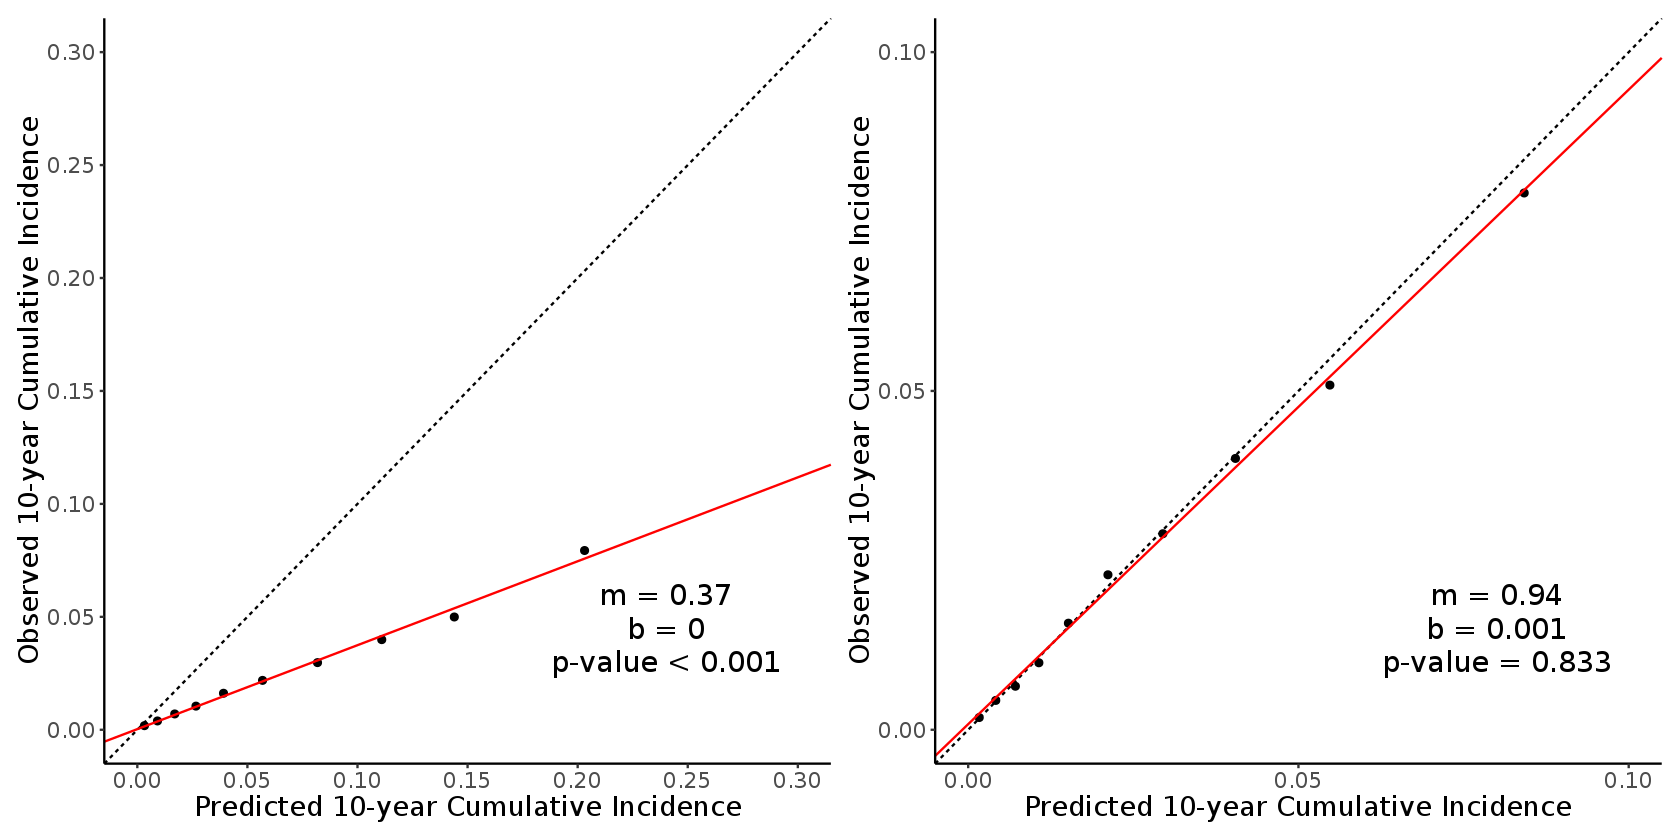

In [125]:
options(repr.plot.width=14,repr.plot.height=7)

framrisk_cal_dev <- calibration_plot(data=masterdf_dev1_pred[!is.na(framrisk)],
                predictioncol='framrisk',
                eventcol='CAD_tenyearoutcome',
                manualpvalue='p-value < 0.001')

framrisk_recal_cal_dev <- calibration_plot(data=masterdf_dev1_pred[!is.na(framrisk_recal)],
                predictioncol='framrisk_recal',
                eventcol='CAD_tenyearoutcome')

fram_plots_dev <- framrisk_cal_dev + framrisk_recal_cal_dev
fram_plots_dev

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/framrisk_calplots_dev.pdf',
#        fram_plots_dev,width=14,height=7)

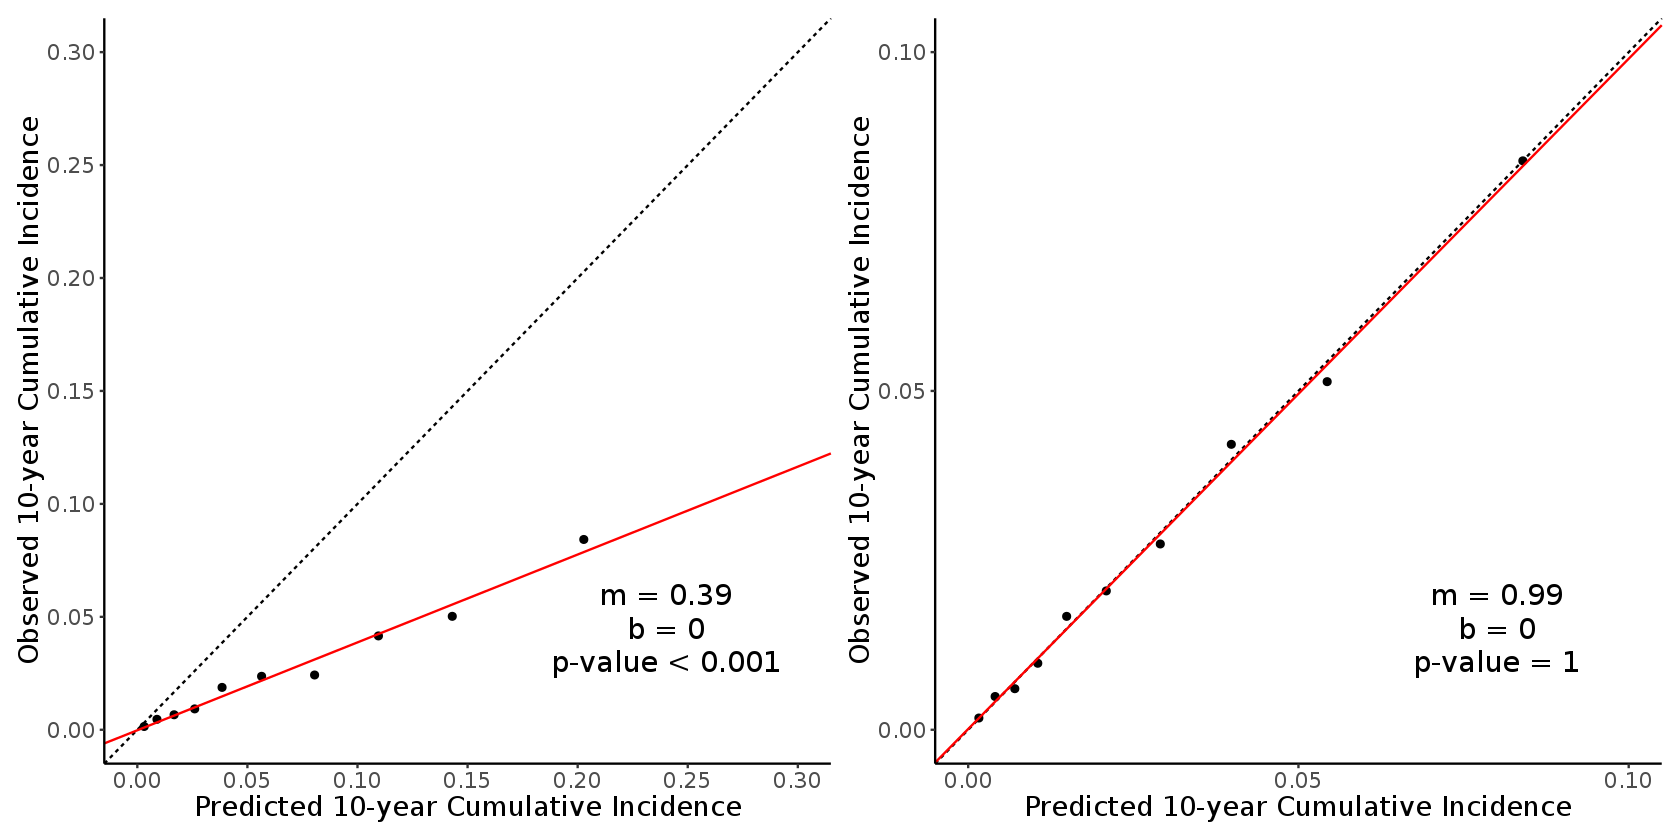

In [126]:
options(repr.plot.width=14,repr.plot.height=7)

framrisk_cal_ho <- calibration_plot(data=masterdf_ho1_pred[!is.na(framrisk)],
                predictioncol='framrisk',
                eventcol='CAD_tenyearoutcome',
                manualpvalue='p-value < 0.001')

framrisk_recal_cal_ho <- calibration_plot(data=masterdf_ho1_pred[!is.na(framrisk_recal)],
                predictioncol='framrisk_recal',
                eventcol='CAD_tenyearoutcome')

fram_plots_ho <- framrisk_cal_ho + framrisk_recal_cal_ho
fram_plots_ho

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/framrisk_calplots.pdf',
#        fram_plots,width=14,height=7)

# Part 6: Benchmarking models with AUC and reclassification indices

In [142]:
#Purpose of this is simply to correctly calculate DeLong p-value between ML4HEN-COX and QRISK3
masterdf_ho1_pred3 <- masterdf_ho1_pred2[!is.na(qrisk3_recal)]

In [148]:
rocobj_coxnet51 <- roc(masterdf_ho1_pred2$CAD_tenyearoutcome,masterdf_ho1_pred2$coxnet51risk)
rocobj_coxnet51_2 <- roc(masterdf_ho1_pred3$CAD_tenyearoutcome,masterdf_ho1_pred3$coxnet51risk)
rocobj_simpcox51risk <- roc(masterdf_ho1_pred2$CAD_tenyearoutcome,masterdf_ho1_pred2$simpcox51risk)
rocobj_simpcox20risk <- roc(masterdf_ho1_pred2$CAD_tenyearoutcome,masterdf_ho1_pred2$simpcox20risk)
rocobj_framrisk <- roc(masterdf_ho1_pred2[!is.na(framrisk_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[!is.na(framrisk_recal)]$framrisk_recal)
rocobj_tenyearASCVD <- roc(masterdf_ho1_pred2[!is.na(tenyearASCVD_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[!is.na(tenyearASCVD_recal)]$tenyearASCVD_recal)
rocobj_qrisk3 <- roc(masterdf_ho1_pred3$CAD_tenyearoutcome,masterdf_ho1_pred3$qrisk3_recal)
rocobj_xgcoxrisk <- roc(masterdf_ho1_pred2$CAD_tenyearoutcome,masterdf_ho1_pred2$xgcoxrisk)

In [147]:
roc.test(rocobj_coxnet51,rocobj_framrisk,method='delong')
roc.test(rocobj_coxnet51,rocobj_tenyearASCVD,method='delong')
roc.test(rocobj_coxnet51_2,rocobj_qrisk3,method='delong')
roc.test(rocobj_coxnet51,rocobj_xgcoxrisk,method='delong')
roc.test(rocobj_coxnet51,rocobj_simpcox51risk,method='delong')
roc.test(rocobj_coxnet51,rocobj_simpcox20risk,method='delong')


	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51 and rocobj_framrisk
Z = 8.339, p-value < 2.2e-16
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7961963   0.7560340 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51 and rocobj_tenyearASCVD
Z = 9.1391, p-value < 2.2e-16
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7961963   0.7538451 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_2 and rocobj_qrisk3
Z = 8.0859, p-value = 6.173e-16
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7967898   0.7608621 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51 and rocobj_xgcoxrisk
Z = -0.19322, p-value = 0.8468
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7961963   0.7966554 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51 and rocobj_simpcox51risk
Z = -0.93521, p-value = 0.3497
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7961963   0.7974452 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51 and rocobj_simpcox20risk
Z = 1.3705, p-value = 0.1705
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7961963   0.7939993 


## Representative example of computing bootstrapped 95% CI for each AUC

In [118]:
ci(rocobj_qrisk3,method='bootstrap',boot.n=1000,progress='text')

  |======================================================================| 100%


95% CI: 0.747-0.7743 (1000 stratified bootstrap replicates)

In [149]:
rocobj_coxnet51_male <- roc(masterdf_ho1_pred2[sex=='Male']$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Male']$coxnet51risk)
rocobj_coxnet51_male_2 <- roc(masterdf_ho1_pred3[sex=='Male']$CAD_tenyearoutcome,masterdf_ho1_pred3[sex=='Male']$coxnet51risk)
rocobj_simpcox51risk_male <- roc(masterdf_ho1_pred2[sex=='Male']$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Male']$simpcox51risk)
rocobj_simpcox20risk_male <- roc(masterdf_ho1_pred2[sex=='Male']$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Male']$simpcox20risk)
rocobj_framrisk_male <- roc(masterdf_ho1_pred2[sex=='Male' & !is.na(framrisk_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Male' & !is.na(framrisk_recal)]$framrisk_recal)
rocobj_tenyearASCVD_male <- roc(masterdf_ho1_pred2[sex=='Male' & !is.na(tenyearASCVD_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Male' & !is.na(tenyearASCVD_recal)]$tenyearASCVD_recal)
rocobj_qrisk3_male <- roc(masterdf_ho1_pred3[sex=='Male']$CAD_tenyearoutcome,masterdf_ho1_pred3[sex=='Male']$qrisk3_recal)
rocobj_xgcoxrisk_male <- roc(masterdf_ho1_pred2[sex=='Male']$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Male']$xgcoxrisk)

In [196]:
roc.test(rocobj_coxnet51_male,rocobj_framrisk_male,method='delong')
roc.test(rocobj_coxnet51_male,rocobj_tenyearASCVD_male,method='delong')
roc.test(rocobj_coxnet51_male_2,rocobj_qrisk3_male,method='delong')
roc.test(rocobj_coxnet51_male,rocobj_xgcoxrisk_male,method='delong')
roc.test(rocobj_coxnet51_male,rocobj_simpcox51risk_male,method='delong')
roc.test(rocobj_coxnet51_male,rocobj_simpcox20risk_male,method='delong')


	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_male and rocobj_framrisk_male
Z = 8.2643, p-value < 2.2e-16
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7514267   0.6903098 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_male and rocobj_tenyearASCVD_male
Z = 8.8399, p-value < 2.2e-16
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7514267   0.6888959 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_male_2 and rocobj_qrisk3_male
Z = 8.2198, p-value < 2.2e-16
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7517724   0.6946158 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_male and rocobj_xgcoxrisk_male
Z = -0.030703, p-value = 0.9755
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7514267   0.7515327 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_male and rocobj_simpcox51risk_male
Z = -0.47251, p-value = 0.6366
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7514267   0.7524972 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_male and rocobj_simpcox20risk_male
Z = 1.03, p-value = 0.303
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7514267   0.7487658 


In [150]:
rocobj_coxnet51_female <- roc(masterdf_ho1_pred2[sex=='Female']$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Female']$coxnet51risk)
rocobj_coxnet51_female_2 <- roc(masterdf_ho1_pred3[sex=='Female']$CAD_tenyearoutcome,masterdf_ho1_pred3[sex=='Female']$coxnet51risk)
rocobj_simpcox51risk_female <- roc(masterdf_ho1_pred2[sex=='Female']$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Female']$simpcox51risk)
rocobj_simpcox20risk_female <- roc(masterdf_ho1_pred2[sex=='Female']$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Female']$simpcox20risk)
rocobj_framrisk_female <- roc(masterdf_ho1_pred2[sex=='Female' & !is.na(framrisk_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Female' & !is.na(framrisk_recal)]$framrisk_recal)
rocobj_tenyearASCVD_female <- roc(masterdf_ho1_pred2[sex=='Female' & !is.na(tenyearASCVD_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Female' & !is.na(tenyearASCVD_recal)]$tenyearASCVD_recal)
rocobj_qrisk3_female <- roc(masterdf_ho1_pred3[sex=='Female']$CAD_tenyearoutcome,masterdf_ho1_pred3[sex=='Female']$qrisk3_recal)
rocobj_xgcoxrisk_female <- roc(masterdf_ho1_pred2[sex=='Female']$CAD_tenyearoutcome,masterdf_ho1_pred2[sex=='Female']$xgcoxrisk)

In [197]:
roc.test(rocobj_coxnet51_female,rocobj_framrisk_female,method='delong')
roc.test(rocobj_coxnet51_female,rocobj_tenyearASCVD_female,method='delong')
roc.test(rocobj_coxnet51_female_2,rocobj_qrisk3_female,method='delong')

roc.test(rocobj_coxnet51_female,rocobj_xgcoxrisk_female,method='delong')
roc.test(rocobj_coxnet51_female,rocobj_simpcox51risk_female,method='delong')
roc.test(rocobj_coxnet51_female,rocobj_simpcox20risk_female,method='delong')


	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_female and rocobj_framrisk_female
Z = 1.7944, p-value = 0.07276
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7801656   0.7584493 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_female and rocobj_tenyearASCVD_female
Z = 2.4635, p-value = 0.01376
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7801656   0.7488223 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_female_2 and rocobj_qrisk3_female
Z = 1.5305, p-value = 0.1259
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7807082   0.7624636 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_female and rocobj_xgcoxrisk_female
Z = -0.68244, p-value = 0.495
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7801656   0.7844449 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_female and rocobj_simpcox51risk_female
Z = -2.0449, p-value = 0.04086
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7801656   0.7852274 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_female and rocobj_simpcox20risk_female
Z = 0.82209, p-value = 0.411
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7801656   0.7773786 


In [151]:
rocobj_coxnet51_under55 <- roc(masterdf_ho1_pred2[age<55]$CAD_tenyearoutcome,masterdf_ho1_pred2[age<55]$coxnet51risk)
rocobj_coxnet51_under55_2 <- roc(masterdf_ho1_pred3[age<55]$CAD_tenyearoutcome,masterdf_ho1_pred3[age<55]$coxnet51risk)
rocobj_simpcox51risk_under55 <- roc(masterdf_ho1_pred2[age<55]$CAD_tenyearoutcome,masterdf_ho1_pred2[age<55]$simpcox51risk)
rocobj_simpcox20risk_under55 <- roc(masterdf_ho1_pred2[age<55]$CAD_tenyearoutcome,masterdf_ho1_pred2[age<55]$simpcox20risk)
rocobj_framrisk_under55 <- roc(masterdf_ho1_pred2[age<55 & !is.na(framrisk_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[age<55 & !is.na(framrisk_recal)]$framrisk_recal)
rocobj_tenyearASCVD_under55 <- roc(masterdf_ho1_pred2[age<55 & !is.na(tenyearASCVD_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[age<55 & !is.na(tenyearASCVD_recal)]$tenyearASCVD_recal)
rocobj_qrisk3_under55 <- roc(masterdf_ho1_pred3[age<55]$CAD_tenyearoutcome,masterdf_ho1_pred3[age<55]$qrisk3_recal)
rocobj_xgcoxrisk_under55 <- roc(masterdf_ho1_pred2[age<55]$CAD_tenyearoutcome,masterdf_ho1_pred2[age<55]$xgcoxrisk)

In [198]:
roc.test(rocobj_coxnet51_under55,rocobj_framrisk_under55,method='delong')
roc.test(rocobj_coxnet51_under55,rocobj_tenyearASCVD_under55,method='delong')
roc.test(rocobj_coxnet51_under55_2,rocobj_qrisk3_under55,method='delong')

roc.test(rocobj_coxnet51_under55,rocobj_xgcoxrisk_under55,method='delong')
roc.test(rocobj_coxnet51_under55,rocobj_simpcox51risk_under55,method='delong')
roc.test(rocobj_coxnet51_under55,rocobj_simpcox20risk_under55,method='delong')


	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_under55 and rocobj_framrisk_under55
Z = 4.7445, p-value = 2.09e-06
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.8249622   0.7671713 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_under55 and rocobj_tenyearASCVD_under55
Z = 5.642, p-value = 1.681e-08
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.8249622   0.7696919 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_under55_2 and rocobj_qrisk3_under55
Z = 3.2495, p-value = 0.001156
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.8228640   0.7903234 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_under55 and rocobj_xgcoxrisk_under55
Z = -1.3139, p-value = 0.1889
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.8249622   0.8318017 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_under55 and rocobj_simpcox51risk_under55
Z = -0.87228, p-value = 0.3831
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.8249622   0.8270251 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_under55 and rocobj_simpcox20risk_under55
Z = 1.5387, p-value = 0.1239
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.8249622   0.8201102 


In [152]:
rocobj_coxnet51_over55 <- roc(masterdf_ho1_pred2[age>=55]$CAD_tenyearoutcome,masterdf_ho1_pred2[age>=55]$coxnet51risk)
rocobj_coxnet51_over55_2 <- roc(masterdf_ho1_pred3[age>=55]$CAD_tenyearoutcome,masterdf_ho1_pred3[age>=55]$coxnet51risk)

rocobj_simpcox51risk_over55 <- roc(masterdf_ho1_pred2[age>=55]$CAD_tenyearoutcome,masterdf_ho1_pred2[age>=55]$simpcox51risk)
rocobj_simpcox20risk_over55 <- roc(masterdf_ho1_pred2[age>=55]$CAD_tenyearoutcome,masterdf_ho1_pred2[age>=55]$simpcox20risk)
rocobj_framrisk_over55 <- roc(masterdf_ho1_pred2[age>=55 & !is.na(framrisk_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[age>=55 & !is.na(framrisk_recal)]$framrisk_recal)
rocobj_tenyearASCVD_over55 <- roc(masterdf_ho1_pred2[age>=55 & !is.na(tenyearASCVD_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[age>=55 & !is.na(tenyearASCVD_recal)]$tenyearASCVD_recal)
rocobj_qrisk3_over55 <- roc(masterdf_ho1_pred3[age>=55]$CAD_tenyearoutcome,masterdf_ho1_pred3[age>=55]$qrisk3_recal)
rocobj_xgcoxrisk_over55 <- roc(masterdf_ho1_pred2[age>=55]$CAD_tenyearoutcome,masterdf_ho1_pred2[age>=55]$xgcoxrisk)

In [199]:
roc.test(rocobj_coxnet51_over55,rocobj_framrisk_over55,method='delong')
roc.test(rocobj_coxnet51_over55,rocobj_tenyearASCVD_over55,method='delong')
roc.test(rocobj_coxnet51_over55_2,rocobj_qrisk3_over55,method='delong')

roc.test(rocobj_coxnet51_over55,rocobj_xgcoxrisk_over55,method='delong')
roc.test(rocobj_coxnet51_over55,rocobj_simpcox51risk_over55,method='delong')
roc.test(rocobj_coxnet51_over55,rocobj_simpcox20risk_over55,method='delong')


	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_over55 and rocobj_framrisk_over55
Z = 6.7892, p-value = 1.128e-11
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7550576   0.7122248 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_over55 and rocobj_tenyearASCVD_over55
Z = 7.3023, p-value = 2.829e-13
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7550576   0.7074719 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_over55_2 and rocobj_qrisk3_over55
Z = 7.478, p-value = 7.545e-14
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7555650   0.7092217 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_over55 and rocobj_xgcoxrisk_over55
Z = 0.47896, p-value = 0.632
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7550576   0.7535038 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_over55 and rocobj_simpcox51risk_over55
Z = -0.25137, p-value = 0.8015
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7550576   0.7555590 



	DeLong's test for two correlated ROC curves

data:  rocobj_coxnet51_over55 and rocobj_simpcox20risk_over55
Z = 0.80284, p-value = 0.4221
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.7550576   0.7531907 


# Sn: Performance of PCE and QRISK3 in CAD vs CVD

In [130]:
rocobj_tenyearASCVD_1 <- roc(masterdf_ho1_pred2[!is.na(tenyearASCVD_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[!is.na(tenyearASCVD_recal)]$tenyearASCVD_recal)
rocobj_qrisk3_1 <- roc(masterdf_ho1_pred2[!is.na(qrisk3_recal)]$CAD_tenyearoutcome,masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal)

rocobj_tenyearASCVD_1
rocobj_qrisk3_1


Call:
roc.default(response = masterdf_ho1_pred2[!is.na(tenyearASCVD_recal)]$CAD_tenyearoutcome,     predictor = masterdf_ho1_pred2[!is.na(tenyearASCVD_recal)]$tenyearASCVD_recal)

Data: masterdf_ho1_pred2[!is.na(tenyearASCVD_recal)]$tenyearASCVD_recal in 33738 controls (masterdf_ho1_pred2[!is.na(tenyearASCVD_recal)]$CAD_tenyearoutcome 0) < 917 cases (masterdf_ho1_pred2[!is.na(tenyearASCVD_recal)]$CAD_tenyearoutcome 1).
Area under the curve: 0.7538


Call:
roc.default(response = masterdf_ho1_pred2[!is.na(qrisk3_recal)]$CAD_tenyearoutcome,     predictor = masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal)

Data: masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal in 33253 controls (masterdf_ho1_pred2[!is.na(qrisk3_recal)]$CAD_tenyearoutcome 0) < 905 cases (masterdf_ho1_pred2[!is.na(qrisk3_recal)]$CAD_tenyearoutcome 1).
Area under the curve: 0.7609

In [131]:
rocobj_tenyearASCVD_1 <- roc(masterdf_ho1_pred2[!is.na(tenyearASCVD)]$CAD_tenyearoutcome,masterdf_ho1_pred2[!is.na(tenyearASCVD)]$tenyearASCVD_recal)
rocobj_qrisk3_1 <- roc(masterdf_ho1_pred2[!is.na(qrisk3)]$CAD_tenyearoutcome,masterdf_ho1_pred2[!is.na(qrisk3)]$qrisk3_recal)

rocobj_tenyearASCVD_1
rocobj_qrisk3_1


Call:
roc.default(response = masterdf_ho1_pred2[!is.na(tenyearASCVD)]$CAD_tenyearoutcome,     predictor = masterdf_ho1_pred2[!is.na(tenyearASCVD)]$tenyearASCVD_recal)

Data: masterdf_ho1_pred2[!is.na(tenyearASCVD)]$tenyearASCVD_recal in 33738 controls (masterdf_ho1_pred2[!is.na(tenyearASCVD)]$CAD_tenyearoutcome 0) < 917 cases (masterdf_ho1_pred2[!is.na(tenyearASCVD)]$CAD_tenyearoutcome 1).
Area under the curve: 0.7538


Call:
roc.default(response = masterdf_ho1_pred2[!is.na(qrisk3)]$CAD_tenyearoutcome,     predictor = masterdf_ho1_pred2[!is.na(qrisk3)]$qrisk3_recal)

Data: masterdf_ho1_pred2[!is.na(qrisk3)]$qrisk3_recal in 33253 controls (masterdf_ho1_pred2[!is.na(qrisk3)]$CAD_tenyearoutcome 0) < 905 cases (masterdf_ho1_pred2[!is.na(qrisk3)]$CAD_tenyearoutcome 1).
Area under the curve: 0.7609

In [134]:
rocobj_tenyearASCVD_1 <- roc(masterdf_ho1_pred2[!is.na(tenyearASCVD)]$CVD_tenyearoutcome,masterdf_ho1_pred2[!is.na(tenyearASCVD)]$tenyearASCVD_recal)
rocobj_qrisk3_1 <- roc(masterdf_ho1_pred2[!is.na(qrisk3)]$CVD_tenyearoutcome,masterdf_ho1_pred2[!is.na(qrisk3)]$qrisk3_recal)
rocobj_coxnet51_1 <- roc(masterdf_ho1_pred2$CVD_tenyearoutcome,masterdf_ho1_pred2$coxnet51risk)

rocobj_tenyearASCVD_1
rocobj_qrisk3_1
rocobj_coxnet51_1


Call:
roc.default(response = masterdf_ho1_pred2[!is.na(tenyearASCVD)]$CVD_tenyearoutcome,     predictor = masterdf_ho1_pred2[!is.na(tenyearASCVD)]$tenyearASCVD_recal)

Data: masterdf_ho1_pred2[!is.na(tenyearASCVD)]$tenyearASCVD_recal in 32588 controls (masterdf_ho1_pred2[!is.na(tenyearASCVD)]$CVD_tenyearoutcome 0) < 2067 cases (masterdf_ho1_pred2[!is.na(tenyearASCVD)]$CVD_tenyearoutcome 1).
Area under the curve: 0.7191


Call:
roc.default(response = masterdf_ho1_pred2[!is.na(qrisk3)]$CVD_tenyearoutcome,     predictor = masterdf_ho1_pred2[!is.na(qrisk3)]$qrisk3_recal)

Data: masterdf_ho1_pred2[!is.na(qrisk3)]$qrisk3_recal in 32142 controls (masterdf_ho1_pred2[!is.na(qrisk3)]$CVD_tenyearoutcome 0) < 2016 cases (masterdf_ho1_pred2[!is.na(qrisk3)]$CVD_tenyearoutcome 1).
Area under the curve: 0.7303


Call:
roc.default(response = masterdf_ho1_pred2$CVD_tenyearoutcome,     predictor = masterdf_ho1_pred2$coxnet51risk)

Data: masterdf_ho1_pred2$coxnet51risk in 32588 controls (masterdf_ho1_pred2$CVD_tenyearoutcome 0) < 2067 cases (masterdf_ho1_pred2$CVD_tenyearoutcome 1).
Area under the curve: 0.7432

In [135]:
ci(rocobj_tenyearASCVD_1,method='bootstrap',boot.n=1000,progress='text')
ci(rocobj_qrisk3_1,method='bootstrap',boot.n=1000,progress='text')
ci(rocobj_coxnet51_1,method='bootstrap',boot.n=1000,progress='text')

  |======================================================================| 100%


95% CI: 0.7087-0.7296 (1000 stratified bootstrap replicates)

  |======================================================================| 100%


95% CI: 0.7195-0.7403 (1000 stratified bootstrap replicates)

  |======================================================================| 100%


95% CI: 0.733-0.7528 (1000 stratified bootstrap replicates)

# Start reclassification analyses

In [137]:
reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$framrisk_recal,
                predrisk2=masterdf_ho1_pred2$coxnet51risk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$tenyearASCVD_recal,
                predrisk2=masterdf_ho1_pred2$coxnet51risk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2[!is.na(qrisk3_recal)],
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal,
                predrisk2=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$coxnet51risk,
                cutoff=c(0,0.025,1))


reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$framrisk_recal,
                predrisk2=masterdf_ho1_pred2$coxnet51risk,
                cutoff=c(0,0.05,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$tenyearASCVD_recal,
                predrisk2=masterdf_ho1_pred2$coxnet51risk,
                cutoff=c(0,0.05,1))

reclass(data=masterdf_ho1_pred2[!is.na(qrisk3_recal)],
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal,
                predrisk2=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$coxnet51risk,
                cutoff=c(0,0.05,1))

 _________________________________________
 
     Reclassification table    
 _________________________________________
, ,  = 0

           c2
c1          [0,0.025) [0.025,1]
  [0,0.025)     18632      2123
  [0.025,1]      2946     10037

, ,  = 1

           c2
c1          [0,0.025) [0.025,1]
  [0,0.025)       125        86
  [0.025,1]        53       653


 Outcome: absent 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)     18632      2123              10
    [0.025,1]      2946     10037              23

 
 Outcome: present 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)       125        86              41
    [0.025,1]        53       653               8

 
 Combined Data 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)     18757      2209              11
    [0.025,1]      2999     10690              22
 _____________________________________

In [138]:
reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$framrisk_recal,
                predrisk2=masterdf_ho1_pred2$simpcox51risk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$tenyearASCVD_recal,
                predrisk2=masterdf_ho1_pred2$simpcox51risk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2[!is.na(qrisk3_recal)],
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal,
                predrisk2=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$simpcox51risk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$framrisk_recal,
                predrisk2=masterdf_ho1_pred2$simpcox51risk,
                cutoff=c(0,0.05,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$tenyearASCVD_recal,
                predrisk2=masterdf_ho1_pred2$simpcox51risk,
                cutoff=c(0,0.05,1))

reclass(data=masterdf_ho1_pred2[!is.na(qrisk3_recal)],
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal,
                predrisk2=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$simpcox51risk,
                cutoff=c(0,0.05,1))

 _________________________________________
 
     Reclassification table    
 _________________________________________
, ,  = 0

           c2
c1          [0,0.025) [0.025,1]
  [0,0.025)     18946      1809
  [0.025,1]      3487      9496

, ,  = 1

           c2
c1          [0,0.025) [0.025,1]
  [0,0.025)       132        79
  [0.025,1]        64       642


 Outcome: absent 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)     18946      1809               9
    [0.025,1]      3487      9496              27

 
 Outcome: present 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)       132        79              37
    [0.025,1]        64       642               9

 
 Combined Data 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)     19078      1888               9
    [0.025,1]      3551     10138              26
 _____________________________________

In [159]:
reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$framrisk_recal,
                predrisk2=masterdf_ho1_pred2$simpcox20risk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$tenyearASCVD_recal,
                predrisk2=masterdf_ho1_pred2$simpcox20risk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2[!is.na(qrisk3_recal)],
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal,
                predrisk2=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$simpcox20risk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$framrisk_recal,
                predrisk2=masterdf_ho1_pred2$simpcox20risk,
                cutoff=c(0,0.05,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$tenyearASCVD_recal,
                predrisk2=masterdf_ho1_pred2$simpcox20risk,
                cutoff=c(0,0.05,1))

reclass(data=masterdf_ho1_pred2[!is.na(qrisk3_recal)],
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal,
                predrisk2=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$simpcox20risk,
                cutoff=c(0,0.05,1))

 _________________________________________
 
     Reclassification table    
 _________________________________________
, ,  = 0

           c2
c1          [0,0.025) [0.025,1]
  [0,0.025)     18887      1868
  [0.025,1]      3311      9672

, ,  = 1

           c2
c1          [0,0.025) [0.025,1]
  [0,0.025)       133        78
  [0.025,1]        64       642


 Outcome: absent 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)     18887      1868               9
    [0.025,1]      3311      9672              26

 
 Outcome: present 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)       133        78              37
    [0.025,1]        64       642               9

 
 Combined Data 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)     19020      1946               9
    [0.025,1]      3375     10314              25
 _____________________________________

In [139]:
reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$framrisk_recal,
                predrisk2=masterdf_ho1_pred2$xgcoxrisk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$tenyearASCVD_recal,
                predrisk2=masterdf_ho1_pred2$xgcoxrisk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2[!is.na(qrisk3_recal)],
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal,
                predrisk2=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$xgcoxrisk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$framrisk_recal,
                predrisk2=masterdf_ho1_pred2$xgcoxrisk,
                cutoff=c(0,0.05,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$tenyearASCVD_recal,
                predrisk2=masterdf_ho1_pred2$xgcoxrisk,
                cutoff=c(0,0.05,1))

reclass(data=masterdf_ho1_pred2[!is.na(qrisk3_recal)],
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal,
                predrisk2=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$xgcoxrisk,
                cutoff=c(0,0.05,1))

 _________________________________________
 
     Reclassification table    
 _________________________________________
, ,  = 0

           c2
c1          [0,0.025) [0.025,1]
  [0,0.025)     18932      1823
  [0.025,1]      3409      9574

, ,  = 1

           c2
c1          [0,0.025) [0.025,1]
  [0,0.025)       134        77
  [0.025,1]        66       640


 Outcome: absent 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)     18932      1823               9
    [0.025,1]      3409      9574              26

 
 Outcome: present 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)       134        77              36
    [0.025,1]        66       640               9

 
 Combined Data 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)     19066      1900               9
    [0.025,1]      3475     10214              25
 _____________________________________

# Making density plots

In [140]:
dtfordensityplots <- masterdf_ho1_pred2[,c('eid','coxnet51risk','simpcox51risk','xgcoxrisk',
                                   'framrisk','tenyearASCVD','qrisk3','framrisk_recal',
                                   'tenyearASCVD_recal','qrisk3_recal')]

In [141]:
names(dtfordensityplots) <- c('eid','ML4HEN-Cox','SimpleCox51','XgCox','FRS','PCE','QRISK3',
                      'FRS(recal)','PCE(recal)','QRISK(recal)')

In [142]:
densityplotdt1 <- melt(dtfordensityplots,id.vars=c('eid'),measure.vars=c('ML4HEN-Cox'))

In [143]:
densityplotdt2 <- melt(dtfordensityplots,id.vars=c('eid'),measure.vars=c('ML4HEN-Cox',
                                                       'FRS(recal)','PCE(recal)',
                                                       'QRISK(recal)'))

In [144]:
densityplotdt3 <- melt(dtfordensityplots,id.vars=c('eid'),measure.vars=c('ML4HEN-Cox','SimpleCox51',
                                                       'XgCox'))

Warning message:
"Removed 286 rows containing non-finite values (stat_density)."
Warning message:
"Removed 910 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1223 rows containing non-finite values (stat_density)."
Warning message:
"Removed 286 rows containing non-finite values (stat_density)."
Warning message:
"Removed 910 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1223 rows containing non-finite values (stat_density)."


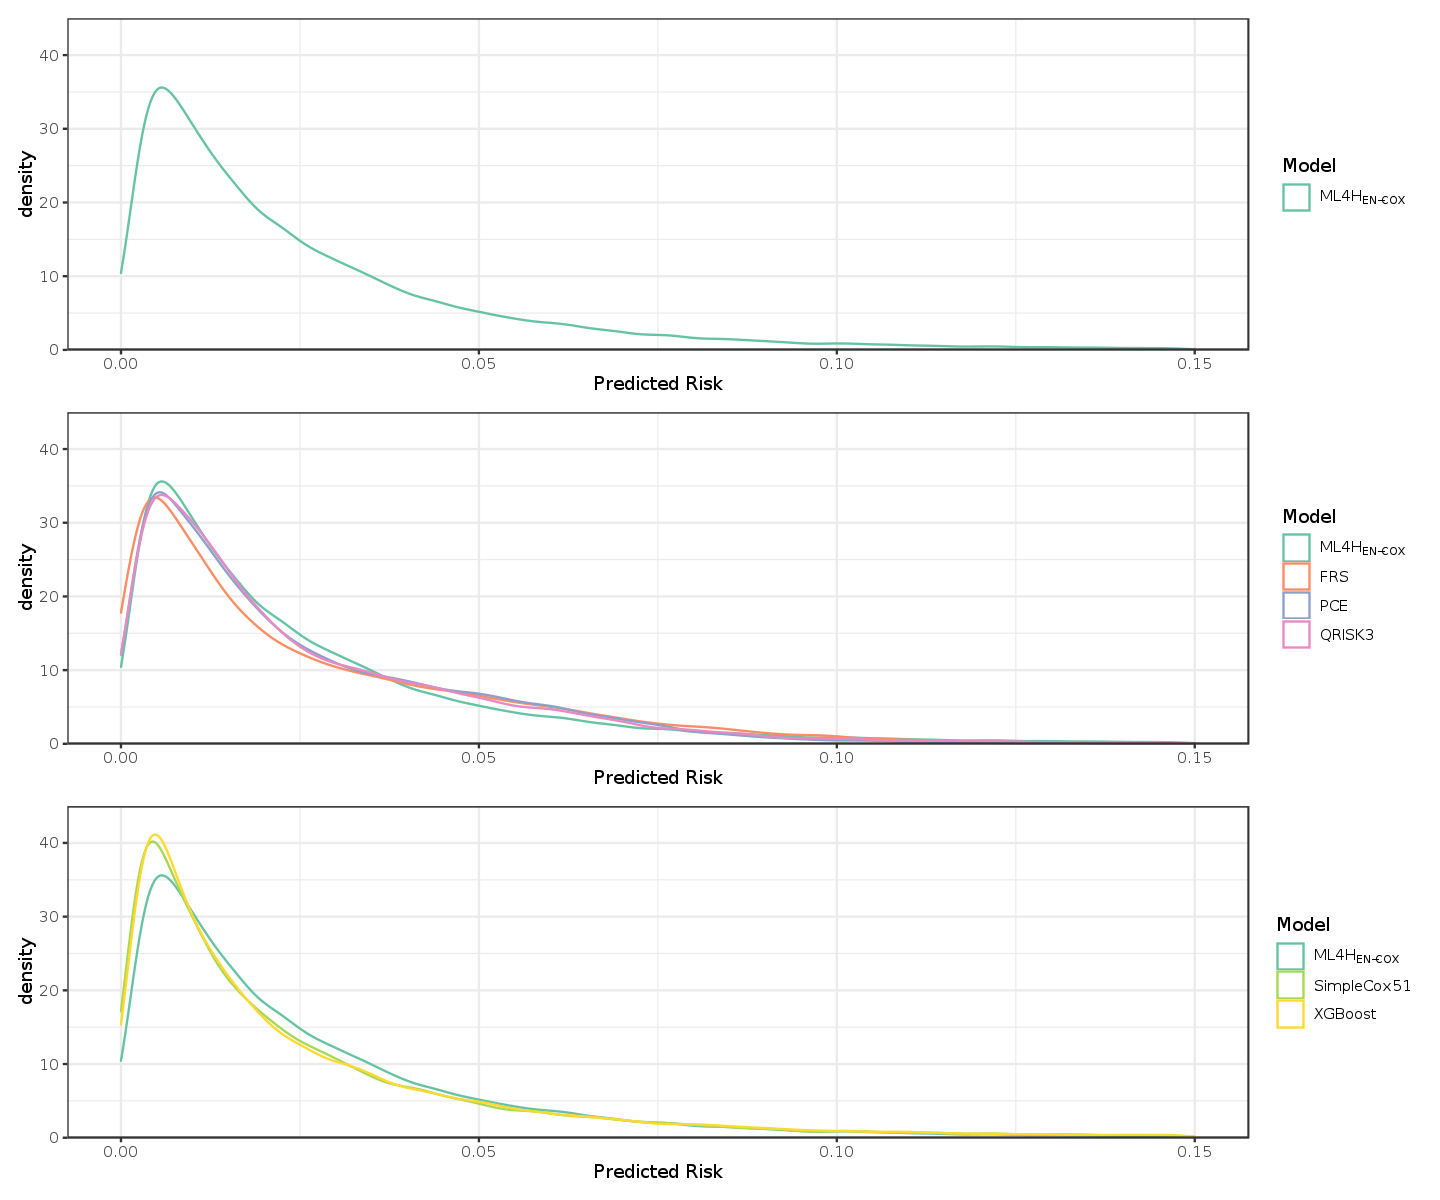

In [166]:
options(repr.plot.width=12,repr.plot.height=10)

g1 <- ggplot(data=densityplotdt1,aes(x=value,colour=variable)) + 
geom_density() +
scale_x_continuous(limits=c(0,0.15)) +
scale_y_continuous(expand=c(0,0),limits=c(0,45)) +
theme_bw() +
xlab('Predicted Risk') +
labs(colour = 'Model') +
scale_color_manual(values=c('#66C2A5'),labels=c(expression(ML4H[EN-COX]))) +
theme(legend.text.align = 0)

g2 <- ggplot(data=densityplotdt2,aes(x=value,colour=variable)) + 
geom_density() +
theme_bw() +
scale_x_continuous(limits=c(0,0.15)) +
scale_y_continuous(expand=c(0,0),limits=c(0,45)) +
xlab('Predicted Risk') +
labs(colour = 'Model') +
scale_color_manual(values=c('#66C2A5','#FC8D62','#8DA0CB','#E78AC3'),
                   labels=c(expression(ML4H[EN-COX]),'FRS','PCE','QRISK3')) +
theme(legend.text.align = 0)

g3 <- ggplot(data=densityplotdt3,aes(x=value,colour=variable)) + 
geom_density() +
theme_bw() +
scale_x_continuous(limits=c(0,0.15)) +
scale_y_continuous(expand=c(0,0),limits=c(0,45)) +
xlab('Predicted Risk') +
labs(colour = 'Model') +
scale_color_manual(values=c('#66C2A5','#A6D854','#FFD92F'),
                   labels=c(expression(ML4H[EN-COX]),'SimpleCox51','XGBoost')) +
theme(legend.text.align = 0)

absriskplots <- g1 + g2 + g3 + plot_layout(ncol = 1)
absriskplots

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/efigure8.pdf',
#        absriskplots,width=12,height=10)

Warning message:
"Removed 94 rows containing non-finite values (stat_density)."
Warning message:
"Removed 94 rows containing non-finite values (stat_density)."


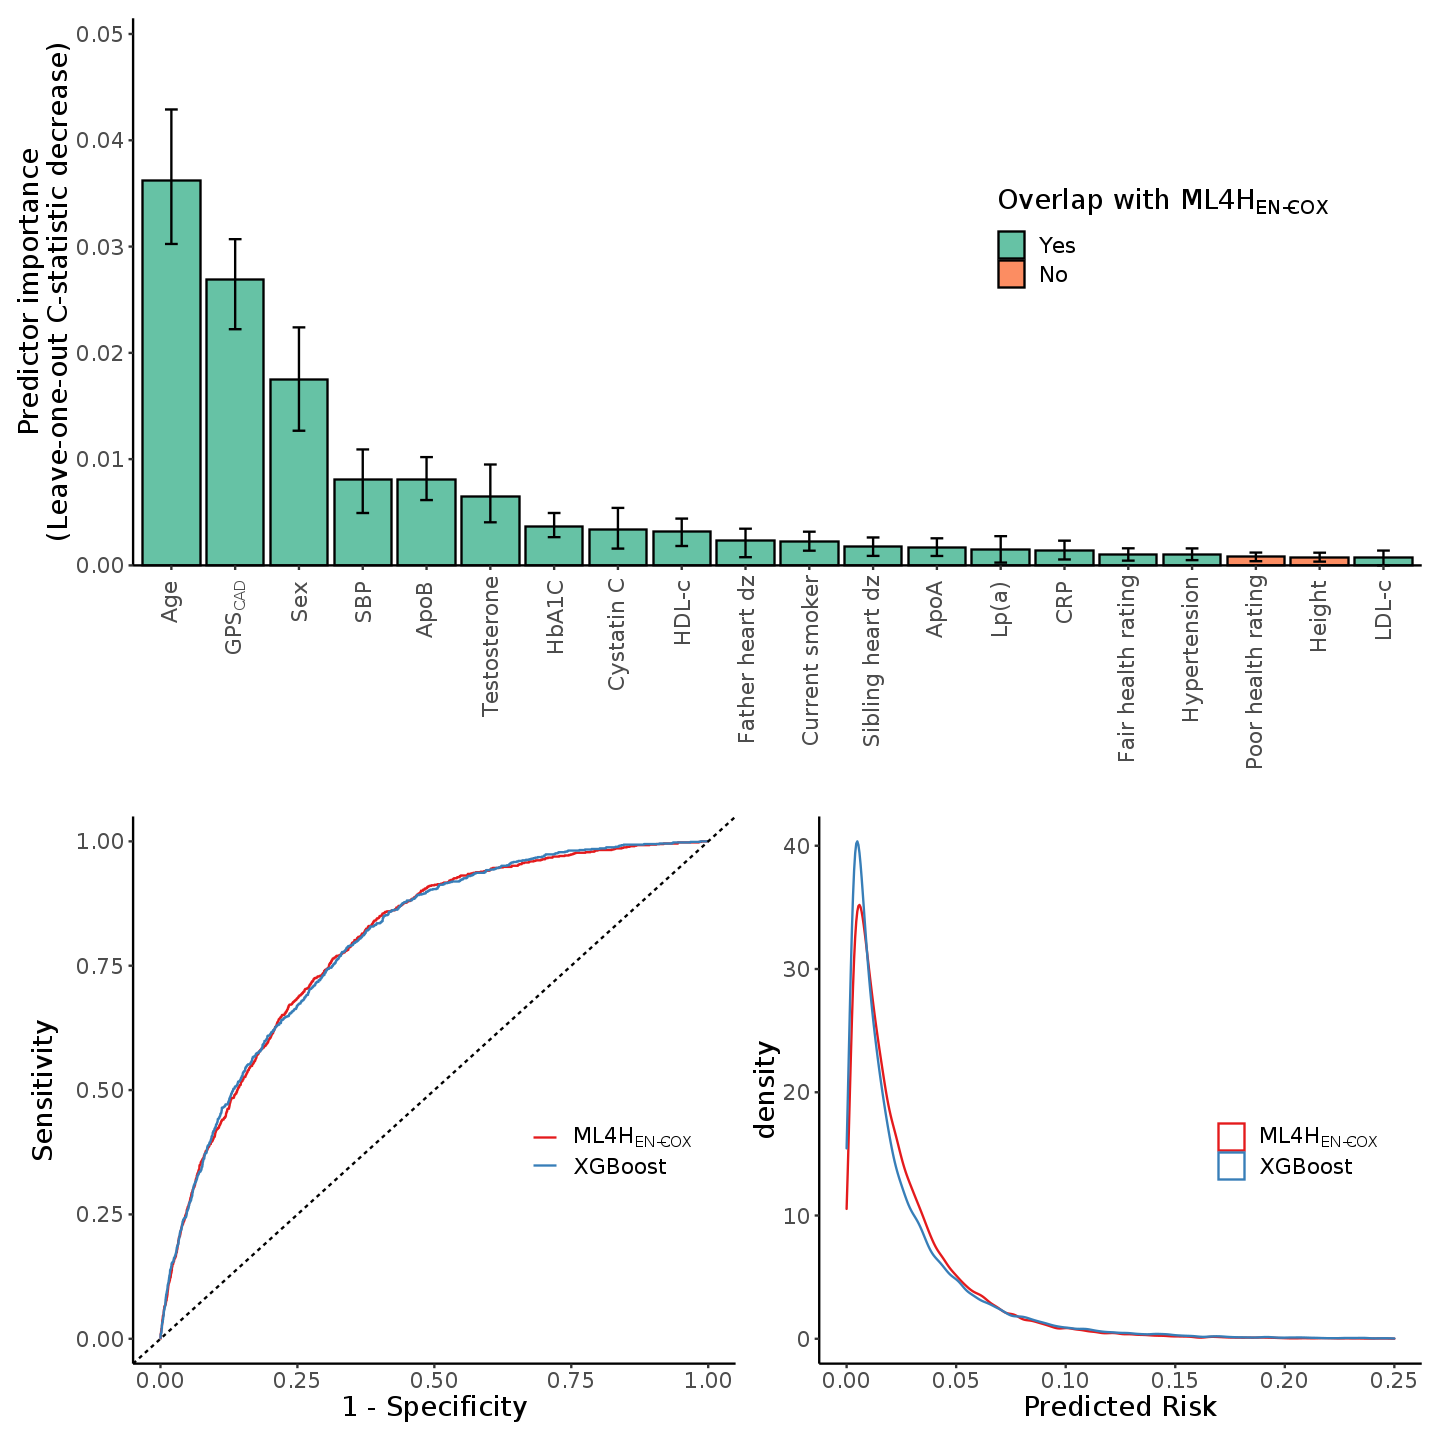

In [218]:
options(repr.plot.width=10,repr.plot.height=10)
densityplotdt4 <- melt(dtfordensityplots,id.vars=c('eid'),measure.vars=c('ML4HEN-Cox','XgCox'))

g4 <- ggplot(data=densityplotdt4,aes(x=value,colour=variable)) + 
geom_density() +
scale_x_continuous(limits=c(0,0.25)) +
theme_classic() +
xlab('Predicted Risk') +
labs(colour = 'Model') +
scale_color_brewer(palette='Set1',labels=c(expression(ML4H[EN-COX]),'XGBoost')) +
theme(text = element_text(size=16),
      legend.position=c(0.8,0.4),
     legend.title=element_blank(),
     legend.text.align=0)

options(repr.plot.width=12,repr.plot.height=12)
efigure11 <- xgCoxFeatPlot / (aucfig2 | g4) + plot_layout(nrow=2,heights = c(2,2))

efigure11

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/efigure11.pdf',
#        efigure11,width=10,height=10)

# Part 7: Making absolute risk plots for GPS, hip, waist

In [84]:
fullfeat_dev <- fread("coxnet__feature_matrix__development_0_0011765691116882482__30Nov_2020.txt")
fullfeat_ho <- fread("coxnet__feature_matrix__holdout_0_0011765691116882482__30Nov_2020.txt")

fullfeat_devUnscaled <- fread('coxnet__feature_matrix_nonzero_model_0_0011765691116882482__development_unscaled__30Nov_2020.txt')
fullfeat_hoUnscaled <- fread('coxnet__feature_matrix_nonzero_model_0_0011765691116882482__holdout_unscaled__30Nov_2020.txt')

In [85]:
prsvec <- quantile(fullfeat_devUnscaled[['d_prsadjscore']],seq(0,1,0.01),na.rm = TRUE)
prsperc <- seq(0,100,1)
        
prsmean <- mean(fullfeat_devUnscaled[['d_prsadjscore']],na.rm=TRUE)
prssd <- sd(fullfeat_devUnscaled[['d_prsadjscore']],na.rm=TRUE)
        
prsvec1 <- (prsvec - prsmean)/prssd
        
agevec <- c(45,55,65)
agevarmean <- mean(fullfeat_devUnscaled[['d_age']],na.rm=TRUE)
agevarsd <- sd(fullfeat_devUnscaled[['d_age']],na.rm=TRUE)
        
prsvec2 <- rep(prsvec1,length(agevec))
agevecrep <- rep(agevec,each=length(prsvec1))
agevecrep_scaled <- (agevecrep - agevarmean)/agevarsd
        
plotdt <- data.table(prsvec2,
                        agevecrep_scaled,
                        rep(prsperc,length(agevec)),
                        agevecrep)
names(plotdt) <- c('d_prsadjscore','d_age','unscaledvar','age_unscaled')
mutnamvec <- names(plotdt)[1:2]
           
modscaleddt <- fullfeat_dev[,-c('index')]
modscaleddtmean <- modscaleddt[,lapply(.SD,mean)]
modscaleddtmeanrep <- modscaleddtmean[rep(seq_len(nrow(modscaleddtmean)),nrow(plotdt))]
        
modscaleddtmeanrep[, (mutnamvec) := plotdt[, .SD, .SDcols=mutnamvec], 
                            .SDcols = mutnamvec]
    
if(!all.equal(coxnet_feature_list_annot_clean$field,names(modscaleddtmeanrep))){
    stop('fields in coefdt and column names in scaleddt not in same order')
}
    
modscaleddtmeanrep[, lp := as.matrix(modscaleddtmeanrep)%*%coxnet_feature_list_annot_clean$coef]
modscaleddtmeanrep[, absrisk := (1 - 0.9876555687885301^exp(lp))]
finaldt <- cbind(modscaleddtmeanrep,
                            plotdt[,.SD,.SDcols=which(names(plotdt) %in% c('unscaledvar','age_unscaled'))])

prsplot <- ggplot(finaldt,aes(x=unscaledvar,y=absrisk*100,
                              color=factor(age_unscaled,levels=c(65,55,45)))) +
    geom_point() +
    scale_y_continuous(limits=c(0,6)) +
    theme_classic() +
    xlab(expression(Adjusted~GPS[CAD]~Percentile)) +
    ylab('Predicted 10-year risk of CAD, %') +
    labs(color = 'Age') +
    scale_color_brewer(palette = 'Set1') +
    theme(text = element_text(size=16),legend.position='none')

In [86]:
hipquant <- quantile(fullfeat_devUnscaled[['d_hip']],c(0.01,0.99),na.rm = TRUE)
hipvec <- seq(hipquant[[1]],hipquant[[2]],length.out=100)
        
hipmean <- mean(fullfeat_devUnscaled[['d_hip']],na.rm=TRUE)
hipsd <- sd(fullfeat_devUnscaled[['d_hip']],na.rm=TRUE)
        
hipvec1 <- (hipvec - hipmean)/hipsd
        
agevec <- c(45,55,65)
agevarmean <- mean(fullfeat_devUnscaled[['d_age']],na.rm=TRUE)
agevarsd <- sd(fullfeat_devUnscaled[['d_age']],na.rm=TRUE)
        
hipvec2 <- rep(hipvec1,length(agevec))
agevecrep <- rep(agevec,each=length(hipvec1))
agevecrep_scaled <- (agevecrep - agevarmean)/agevarsd
        
plotdt <- data.table(hipvec2,
                        agevecrep_scaled,
                        rep(hipvec,length(agevec)),
                        agevecrep)
names(plotdt) <- c('d_hip','d_age','unscaledvar','age_unscaled')
mutnamvec <- names(plotdt)[1:2]
           
modscaleddt <- fullfeat_dev[,-c('index')]
modscaleddtmean <- modscaleddt[,lapply(.SD,mean)]
modscaleddtmeanrep <- modscaleddtmean[rep(seq_len(nrow(modscaleddtmean)),nrow(plotdt))]
        
modscaleddtmeanrep[, (mutnamvec) := plotdt[, .SD, .SDcols=mutnamvec], 
                            .SDcols = mutnamvec]
    
if(!all.equal(coxnet_feature_list_annot_clean$field,names(modscaleddtmeanrep))){
    stop('fields in coefdt and column names in scaleddt not in same order')
}
    
modscaleddtmeanrep[, lp := as.matrix(modscaleddtmeanrep)%*%coxnet_feature_list_annot_clean$coef]
modscaleddtmeanrep[, absrisk := (1 - 0.9876555687885301^exp(lp))]
finaldt <- cbind(modscaleddtmeanrep,
                            plotdt[,.SD,.SDcols=which(names(plotdt) %in% c('unscaledvar','age_unscaled'))])

hipplot <- ggplot(finaldt,aes(x=unscaledvar,y=absrisk*100,
                              color=factor(age_unscaled,levels=c(65,55,45)))) +
    geom_point() +
    scale_y_continuous(limits=c(0,6)) +
    theme_classic() +
    xlab('Hip circumference (cm)') +
    ylab('') +
    labs(color = 'Age') +
    scale_color_brewer(palette = 'Set1') +
    theme(text = element_text(size=16),legend.position='none')

In [87]:
waistquant <- quantile(fullfeat_devUnscaled[['d_waist']],c(0.01,0.99),na.rm = TRUE)
waistvec <- seq(waistquant[[1]],waistquant[[2]],length.out=100)
        
waistmean <- mean(fullfeat_devUnscaled[['d_waist']],na.rm=TRUE)
waistsd <- sd(fullfeat_devUnscaled[['d_waist']],na.rm=TRUE)
        
waistvec1 <- (waistvec - waistmean)/waistsd
        
agevec <- c(45,55,65)
agevarmean <- mean(fullfeat_devUnscaled[['d_age']],na.rm=TRUE)
agevarsd <- sd(fullfeat_devUnscaled[['d_age']],na.rm=TRUE)
        
waistvec2 <- rep(waistvec1,length(agevec))
agevecrep <- rep(agevec,each=length(waistvec1))
agevecrep_scaled <- (agevecrep - agevarmean)/agevarsd
        
plotdt <- data.table(waistvec2,
                        agevecrep_scaled,
                        rep(waistvec,length(agevec)),
                        agevecrep)
names(plotdt) <- c('d_waist','d_age','unscaledvar','age_unscaled')
mutnamvec <- names(plotdt)[1:2]
           
modscaleddt <- fullfeat_dev[,-c('index')]
modscaleddtmean <- modscaleddt[,lapply(.SD,mean)]
modscaleddtmeanrep <- modscaleddtmean[rep(seq_len(nrow(modscaleddtmean)),nrow(plotdt))]
        
modscaleddtmeanrep[, (mutnamvec) := plotdt[, .SD, .SDcols=mutnamvec], 
                            .SDcols = mutnamvec]
    
if(!all.equal(coxnet_feature_list_annot_clean$field,names(modscaleddtmeanrep))){
    stop('fields in coefdt and column names in scaleddt not in same order')
}
    
modscaleddtmeanrep[, lp := as.matrix(modscaleddtmeanrep)%*%coxnet_feature_list_annot_clean$coef]
modscaleddtmeanrep[, absrisk := (1 - 0.9876555687885301^exp(lp))]
finaldt <- cbind(modscaleddtmeanrep,
                            plotdt[,.SD,.SDcols=which(names(plotdt) %in% c('unscaledvar','age_unscaled'))])

waistplot <- ggplot(finaldt,aes(x=unscaledvar,y=absrisk*100,
                              color=factor(age_unscaled,levels=c(65,55,45)))) +
    geom_point() +
    scale_y_continuous(limits=c(0,6)) +
    theme_classic() +
    xlab('Waist circumference (cm)') +
    ylab('') +
    labs(color = 'Age') +
    scale_color_brewer(palette = 'Set1') +
    theme(text = element_text(size=16),legend.position=c(0.7,0.8))

Warning message:
"Removed 2 rows containing missing values (geom_point)."


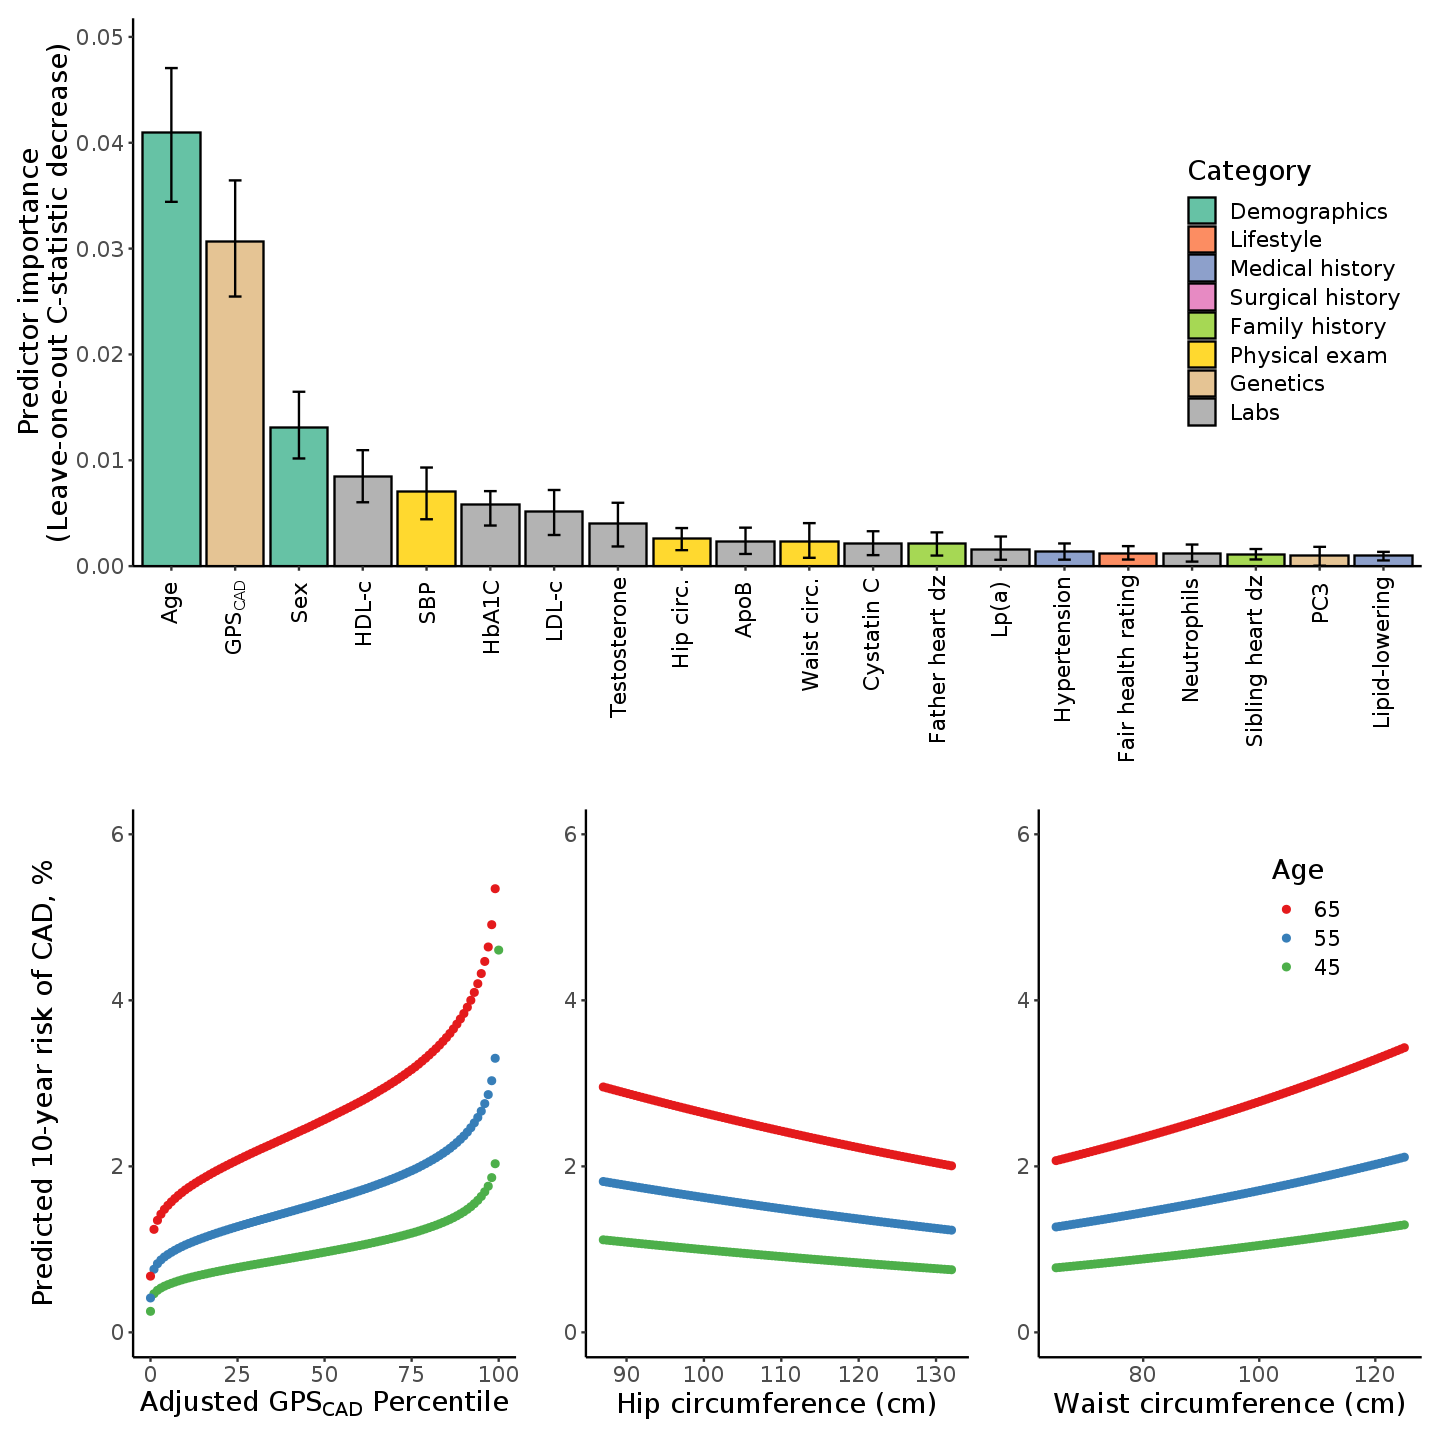

In [88]:
options(repr.plot.width=12,repr.plot.height=12)
figure3 <- featplot / (prsplot | hipplot | waistplot) + plot_layout(nrow=2)
figure3

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/figure3.pdf',
#         figure3,width=12,height=12)

# Revision sensitivity analysis: situation where GPSCAD is not known so the mean is assumed

In [90]:
# names(plotdt) <- c('d_waist','d_age','unscaledvar','age_unscaled')
# mutnamvec <- names(plotdt)[1:2]
           
modscaleddt <- copy(fullfeat_ho)
modscaleddt[,d_prsadjscore:=0]
    
modscaleddt[, lp := as.matrix(modscaleddt[,-c('index')])%*%coxnet_feature_list_annot_clean$coef]
modscaleddt[, coxnetNoPrsRisk := (1 - 0.9876555687885301^exp(lp))]

In [91]:
masterdf_ho1_pred2 <- merge(masterdf_ho1_pred2,modscaleddt[,c('index','coxnetNoPrsRisk')],by.x='eid',by.y='index')

In [92]:
dim(masterdf_ho1_pred2)
head(masterdf_ho1_pred2)

[1] 34655    78

eid,age,sex,ethnicity,ethnicity_code,PC1,PC2,PC3,PC4,PC5,...,LDL_C,subgroup_indicator,tenyearASCVD_recal,qrisk3_recal,framrisk_recal,coxnet51risk,simpcox51risk,simpcox20risk,xgcoxrisk,coxnetNoPrsRisk
<int>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000232,43.71944,Female,British,1001,-12.91670,5.08377,-1.089720,-2.2859100,-6.90542,...,3.229,2,0.001757324,0.001462861,0.0012116892,0.006535622,0.004892421,0.005192621,0.003718019,0.003025356
1000392,42.93889,Female,British,1001,-12.04340,3.22673,1.910530,-2.7038100,-2.69883,...,2.717,2,0.001508545,0.001161906,0.0007615303,0.001833585,0.001315272,0.001559089,0.001036406,0.001660221
1000568,51.78056,Male,British,1001,-14.00040,3.92046,-0.798917,0.0691867,-5.78224,...,4.186,2,0.028727522,0.023086399,0.0327029635,0.041642958,0.038252791,0.052457433,0.036434710,0.025487610
1000711,50.08889,Male,British,1001,-12.30520,4.51805,-1.485550,0.9102100,-7.25386,...,4.201,2,0.038300544,0.022400773,0.0712978742,0.031843175,0.028313262,0.028470601,0.024375916,0.028590163
1000728,47.67778,Male,British,1001,-12.47270,3.88398,-1.610110,2.7449000,-5.29334,...,3.704,2,0.012651263,0.015257630,0.0106985365,0.011572426,0.010961172,0.011967962,0.010108650,0.011165400
1000967,46.92778,Female,British,1001,-1.47628,-16.54520,0.212508,2.6966500,-2.67855,...,2.723,2,0.002080059,0.001786414,0.0010697323,0.002245012,0.001406153,0.001631431,0.002299190,0.002219333


In [93]:
rocobj_coxnetNoPrs <- roc(masterdf_ho1_pred2$CAD_tenyearoutcome,masterdf_ho1_pred2$coxnetNoPrsRisk)
rocobj_coxnetNoPrs


Call:
roc.default(response = masterdf_ho1_pred2$CAD_tenyearoutcome,     predictor = masterdf_ho1_pred2$coxnetNoPrsRisk)

Data: masterdf_ho1_pred2$coxnetNoPrsRisk in 33738 controls (masterdf_ho1_pred2$CAD_tenyearoutcome 0) < 917 cases (masterdf_ho1_pred2$CAD_tenyearoutcome 1).
Area under the curve: 0.7795

In [145]:
ci(rocobj_coxnetNoPrs,method='bootstrap',boot.n=1000,progress='text')

  |======================================================================| 100%


95% CI: 0.7667-0.7928 (1000 stratified bootstrap replicates)

In [146]:
reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$framrisk_recal,
                predrisk2=masterdf_ho1_pred2$coxnetNoPrsRisk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$tenyearASCVD_recal,
                predrisk2=masterdf_ho1_pred2$coxnetNoPrsRisk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2[!is.na(qrisk3_recal)],
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal,
                predrisk2=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$coxnetNoPrsRisk,
                cutoff=c(0,0.025,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$framrisk_recal,
                predrisk2=masterdf_ho1_pred2$coxnetNoPrsRisk,
                cutoff=c(0,0.05,1))

reclass(data=masterdf_ho1_pred2,
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2$tenyearASCVD_recal,
                predrisk2=masterdf_ho1_pred2$coxnetNoPrsRisk,
                cutoff=c(0,0.05,1))

reclass(data=masterdf_ho1_pred2[!is.na(qrisk3_recal)],
                 cOutcome="CAD_tenyearoutcome",
                predrisk1=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$qrisk3_recal,
                predrisk2=masterdf_ho1_pred2[!is.na(qrisk3_recal)]$coxnetNoPrsRisk,
                cutoff=c(0,0.05,1))

 _________________________________________
 
     Reclassification table    
 _________________________________________
, ,  = 0

           c2
c1          [0,0.025) [0.025,1]
  [0,0.025)     19439      1316
  [0.025,1]      2331     10652

, ,  = 1

           c2
c1          [0,0.025) [0.025,1]
  [0,0.025)       165        46
  [0.025,1]        54       652


 Outcome: absent 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)     19439      1316               6
    [0.025,1]      2331     10652              18

 
 Outcome: present 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)       165        46              22
    [0.025,1]        54       652               8

 
 Combined Data 
  
             Updated Model
Initial Model [0,0.025) [0.025,1]  % reclassified
    [0,0.025)     19604      1362               6
    [0.025,1]      2385     11304              17
 _____________________________________

## Making gradient plots to put in Figure 4

In [94]:
names(masterdf_ho1_pred2)

[1] "eid"                  "age"                  "sex"                 
 [4] "ethnicity"            "ethnicity_code"       "PC1"                 
 [7] "PC2"                  "PC3"                  "PC4"                 
[10] "PC5"                  "PC6"                  "PC7"                 
[13] "PC8"                  "PC9"                  "PC10"                
[16] "PC11"                 "PC12"                 "PC13"                
[19] "PC14"                 "PC15"                 "PC16"                
[22] "PC17"                 "PC18"                 "PC19"                
[25] "PC20"                 "PClog"                "prs"                 
[28] "testing_set"          "probableT2DM"         "possibleT2DM"        
[31] "strictT1DM"           "antihtnrx"            "Cholesterol"         
[34] "HDL_C"                "systolicbp"           "currentsmoker"       
[37] "DM"                   "tenyearASCVD"         "PCEcalc"             
[40] "framcalc"             "framrisk"             "CAD_incident_disease"
[43] "CAD_fu_days"          "CAD_fu_yrs"           "CAD_tenyearoutcome"  
[46] "CAD_tenyearcensor"    "CVD_incident_disease" "CVD_fu_days"         
[49] "CVD_fu_yrs"           "CVD_tenyearoutcome"   "CVD_tenyearcensor"   
[52] "qrisk3"               "sex_strat"            "ethnicity_white"     
[55] "ethnicity_black"      "ethnicity_asian"      "ethnicity_southasian"
[58] "ethnicity_other"      "ethnicity_group"      "age_group"           
[61] "ageG2"                "ageG3"                "ageG4"               
[64] "ageG5"                "ageG6"                "ageG7"               
[67] "CAD_fu_days10yr"      "prs_resid"            "LDL_C"               
[70] "subgroup_indicator"   "tenyearASCVD_recal"   "qrisk3_recal"        
[73] "framrisk_recal"       "coxnet51risk"         "simpcox51risk"       
[76] "simpcox20risk"        "xgcoxrisk"            "coxnetNoPrsRisk"

In [95]:
masterdf_ho1_pred2[,coxnet51riskQuintiles := quantcut(coxnet51risk,5,labels=paste0('Q',1:5),ordered=TRUE)]
masterdf_ho1_pred2[,coxnet51riskDeciles := quantcut(coxnet51risk,4,labels=paste0('Q',1:4),ordered=TRUE)]

masterdf_ho1_pred2[,simpcox51riskQuintiles := quantcut(simpcox51risk,5,labels=paste0('Q',1:5),ordered=TRUE)]
masterdf_ho1_pred2[,simpcox51riskDeciles := quantcut(simpcox51risk,4,labels=paste0('Q',1:4),ordered=TRUE)]

masterdf_ho1_pred2[,framrisk_recalQuintiles := quantcut(framrisk_recal,5,labels=paste0('Q',1:5),ordered=TRUE)]
masterdf_ho1_pred2[,framrisk_recalDeciles := quantcut(framrisk_recal,4,labels=paste0('Q',1:4),ordered=TRUE)]

masterdf_ho1_pred2[,tenyearASCVD_recalQuintiles := quantcut(tenyearASCVD_recal,5,labels=paste0('Q',1:5),ordered=TRUE)]
masterdf_ho1_pred2[,tenyearASCVD_recalDeciles := quantcut(tenyearASCVD_recal,4,labels=paste0('Q',1:4),ordered=TRUE)]

masterdf_ho1_pred2[,qrisk3_recalQuintiles := quantcut(qrisk3_recal,5,labels=paste0('Q',1:5),ordered=TRUE)]
masterdf_ho1_pred2[,qrisk3_recalDeciles := quantcut(qrisk3_recal,4,labels=paste0('Q',1:4),ordered=TRUE)]

masterdf_ho1_pred2[,framriskQuintiles := quantcut(framrisk,5,labels=paste0('Q',1:5),ordered=TRUE)]
masterdf_ho1_pred2[,framriskDeciles := quantcut(framrisk,4,labels=paste0('Q',1:4),ordered=TRUE)]

masterdf_ho1_pred2[,tenyearASCVDQuintiles := quantcut(tenyearASCVD,5,labels=paste0('Q',1:5),ordered=TRUE)]
masterdf_ho1_pred2[,tenyearASCVDDeciles := quantcut(tenyearASCVD,4,labels=paste0('Q',1:4),ordered=TRUE)]

masterdf_ho1_pred2[,qrisk3Quintiles := quantcut(qrisk3,5,labels=paste0('Q',1:5),ordered=TRUE)]
masterdf_ho1_pred2[,qrisk3Deciles := quantcut(qrisk3,4,labels=paste0('Q',1:4),ordered=TRUE)]

In [96]:
coxnet51riskQuintilesCalc <- 
masterdf_ho1_pred2[order(coxnet51riskQuintiles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='coxnet51riskQuintiles']
names(coxnet51riskQuintilesCalc) <- c('quant','coxnet51Q20')

coxnet51riskDecilesCalc <- 
masterdf_ho1_pred2[order(coxnet51riskDeciles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='coxnet51riskDeciles']
names(coxnet51riskDecilesCalc) <- c('quant','coxnet51Q10')



simpcox51riskQuintilesCalc <- 
masterdf_ho1_pred2[order(simpcox51riskQuintiles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='simpcox51riskQuintiles']
names(simpcox51riskQuintilesCalc) <- c('quant','simpcox51Q20')

simpcox51riskDecilesCalc <- 
masterdf_ho1_pred2[order(simpcox51riskDeciles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='simpcox51riskDeciles']
names(simpcox51riskDecilesCalc) <- c('quant','simpcox51Q10')




framrisk_recalQuintilesCalc <- 
masterdf_ho1_pred2[order(framrisk_recalQuintiles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='framrisk_recalQuintiles']
names(framrisk_recalQuintilesCalc) <- c('quant','framriskQ20')

framrisk_recalDecilesCalc <- 
masterdf_ho1_pred2[order(framrisk_recalDeciles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='framrisk_recalDeciles']
names(framrisk_recalDecilesCalc) <- c('quant','framriskQ10')



tenyearASCVD_recalQuintilesCalc <- 
masterdf_ho1_pred2[order(tenyearASCVD_recalQuintiles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='tenyearASCVD_recalQuintiles']
names(tenyearASCVD_recalQuintilesCalc) <- c('quant','PCEQ20')

tenyearASCVD_recalDecilesCalc <- 
masterdf_ho1_pred2[order(tenyearASCVD_recalDeciles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='tenyearASCVD_recalDeciles']
names(tenyearASCVD_recalDecilesCalc) <- c('quant','PCEQ10')



qrisk3_recalQuintilesCalc <- 
masterdf_ho1_pred2[order(qrisk3_recalQuintiles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='qrisk3_recalQuintiles']
names(qrisk3_recalQuintilesCalc) <- c('quant','qrisk3Q20')
qrisk3_recalQuintilesCalc <- qrisk3_recalQuintilesCalc[!is.na(quant)]

qrisk3_recalDecilesCalc <- 
masterdf_ho1_pred2[order(qrisk3_recalDeciles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='qrisk3_recalDeciles']
names(qrisk3_recalDecilesCalc) <- c('quant','qrisk3Q10')
qrisk3_recalDecilesCalc <- qrisk3_recalDecilesCalc[!is.na(quant)]


framriskQuintilesCalc <- 
masterdf_ho1_pred2[order(framriskQuintiles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='framriskQuintiles']
names(framriskQuintilesCalc) <- c('quant','framriskRawQ20')

framriskDecilesCalc <- 
masterdf_ho1_pred2[order(framriskDeciles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='framriskDeciles']
names(framriskDecilesCalc) <- c('quant','framriskRawQ10')



tenyearASCVDQuintilesCalc <- 
masterdf_ho1_pred2[order(tenyearASCVDQuintiles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='tenyearASCVDQuintiles']
names(tenyearASCVDQuintilesCalc) <- c('quant','PCERawQ20')

tenyearASCVDDecilesCalc <- 
masterdf_ho1_pred2[order(tenyearASCVDDeciles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='tenyearASCVDDeciles']
names(tenyearASCVDDecilesCalc) <- c('quant','PCERawQ10')



qrisk3QuintilesCalc <- 
masterdf_ho1_pred2[order(qrisk3Quintiles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='qrisk3Quintiles']
names(qrisk3QuintilesCalc) <- c('quant','qrisk3RawQ20')
qrisk3QuintilesCalc <- qrisk3QuintilesCalc[!is.na(quant)]

qrisk3DecilesCalc <- 
masterdf_ho1_pred2[order(qrisk3Deciles),
                   lapply(.SD,mean),.SDcols='CAD_tenyearoutcome',
                   by='qrisk3Deciles']
names(qrisk3DecilesCalc) <- c('quant','qrisk3RawQ10')
qrisk3DecilesCalc <- qrisk3DecilesCalc[!is.na(quant)]

In [97]:
Quintilesdt <- merge(coxnet51riskQuintilesCalc,simpcox51riskQuintilesCalc,by='quant')
Quintilesdt <- merge(Quintilesdt,framrisk_recalQuintilesCalc,by='quant')
Quintilesdt <- merge(Quintilesdt,tenyearASCVD_recalQuintilesCalc,by='quant')
Quintilesdt <- merge(Quintilesdt,qrisk3_recalQuintilesCalc,by='quant')
Quintilesdt <- merge(Quintilesdt,framriskQuintilesCalc,by='quant')
Quintilesdt <- merge(Quintilesdt,tenyearASCVDQuintilesCalc,by='quant')
Quintilesdt <- merge(Quintilesdt,qrisk3QuintilesCalc,by='quant')

In [98]:
Quintilesdtmelted <- melt(Quintilesdt,id.vars=c('quant'),
                        measure.vars=c('coxnet51Q20','simpcox51Q20',
                                      'framriskQ20','PCEQ20','qrisk3Q20',
                                      'framriskRawQ20','PCERawQ20','qrisk3RawQ20'))

In [99]:
Quintilesdtmelted$variable <- factor(Quintilesdtmelted$variable,
                                  levels=c('coxnet51Q20','simpcox51Q20',
                                      'framriskQ20','PCEQ20','qrisk3Q20',
                                          'framriskRawQ20','PCERawQ20','qrisk3RawQ20'),
                                  ordered=TRUE,labels=c('ML4HEN-Cox','SimpleCox51',
                                                       'FRS(recal)','PCE(recal)',
                                                       'QRISK(recal)','FRS(raw)',
                                                       'PCE(raw)','QRISK(raw)'))

In [101]:
QuintilesdtmeltedFig4 <- melt(Quintilesdt,id.vars=c('quant'),
                        measure.vars=c('coxnet51Q20',
                                      'framriskQ20','PCEQ20','qrisk3Q20'))

QuintilesdtmeltedFig4$variable <- factor(QuintilesdtmeltedFig4$variable,
                                  levels=c('coxnet51Q20',
                                      'framriskQ20','PCEQ20','qrisk3Q20'),
                                  ordered=TRUE,labels=c('ML4HEN-Cox',
                                                       'FRS','PCE',
                                                       'QRISK3'))

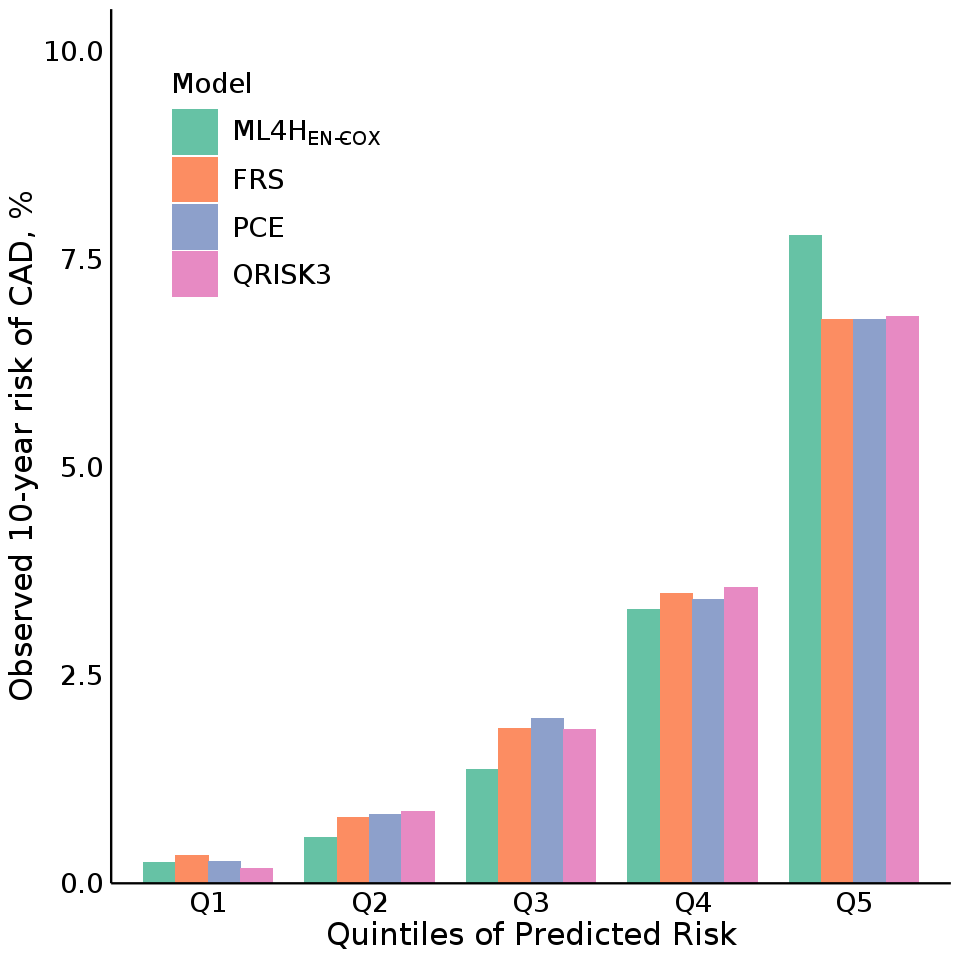

In [102]:
options(repr.plot.width=8,repr.plot.height=8)
QuintilesgradFig4 <- ggplot(QuintilesdtmeltedFig4,aes(x=quant,y=value*100,
                              fill=variable)) +
    geom_bar(stat='identity',width=0.8,position='dodge') +
    scale_y_continuous(limits=c(0,10.5),expand=c(0,0)) +
    theme_classic() +
    xlab('Quintiles of Predicted Risk') +
    ylab('Observed 10-year risk of CAD, %') +
    labs(fill = 'Model') +
    scale_fill_brewer(palette = 'Set2',labels=c(expression(ML4H[EN-COX]),'FRS','PCE','QRISK3')) +
    theme(axis.title.y = element_text(size=18),
          axis.text.y = element_text(size=16,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=18),
          axis.text.x = element_text(size=16,color='black'),
          axis.ticks.x = element_blank(),
          legend.position=c(0.2,0.8),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16))

QuintilesgradFig4

# ggsave('/medpop/esp2/sagrawal/mi_mlprediction/2020.11.30_marcus/mlpaperplots/figure4_gradient.pdf',
#         QuintilesgradFig4,width=8,height=8)